# Calibrating the IFT Cloud Mask
The goal with the cloud clearing algorithm is to filter out areas where the cloud cover is too thick for any ice to be retrieved. This is a two-step process with multiple adjustable parameters: first all cloudy pixels are selected and added to the mask, then cloudy pixels that are likely to have visible ice are removed from the mask. Both steps use thresholds for intensity values from band 7 and band 2 of the MODIS false color imagery (7-2-1). The true color imagery can also be helpful, which includes bands 1-4-3. The algorithm is equivalent to production of a bifurcation of the Band 2 to Band 7 color reflectance plane.

Let the intensity value of band $i$ be given by $B_i$. The module then creates a binary mask with the following steps:
1. $A \gets $ Pixels with $B_7 > 110 = \tau_{init}$.
2. $B \gets $ Pixels with $B_7 < 200 = \tau_7$ and $B_2 > 190 = \tau_2$.
3. $C \gets$ Pixels with $B_7/B_2 < 0.75 = \tau_{7:2}$.
4. All clouds $\gets A$
5. Opaque clouds $\gets A \setminus (B \cap C)$

This algorithm is defined in Lopez-Acosta et al. 2019, with somewhat ambiguous wording regarding how sets $B$ and $C$ should be included. The algorithm defines a parameterized piecewise linear function partitioning B7 vs B2 space, with pixel reflectances on one side of the line classified as clouds, and on the other as cloud free (or thin cloud with sea ice). For the updated version of the software, we have the option to either set new parameters for the LA2019 algorithm, or to develop a new version. For example, replacing step 5 by
$$ \text{Opaque clouds} \gets A \setminus (B \cup C) $$
changes the shape of the curve substantially (while being just as consistent with the description in the LA2019 paper).

## Potential improvements
We use the 






We evaluate the algorithm in two parts. First, we search for an optimum value for the cloud threshold $\tau_{init}$. The fraction of pixels with $B_7 > T_C$ is the estimated total cloud fraction $\hat{F}$. We evaluate this against both the manual cloud fraction (visual, human) estimate and against the MODIS cloud fraction. With the MODIS cloud fraction, we can compare the spatial maps in 5-km pixel blocks rather than image-wide averaging.

The second task is setting the thresholds for $\tau_7, \tau_2$, and $\tau_{7:2}$. These thresholds are chosen based on the 2D histogram data from opaque clouds and from 

We select 2/3 of the cases at random as the training dataset. To this subset, we apply $k$-fold cross validation, optimizing the choice of cloud threshold across $T_C = 0, 10, 20, \cdots, 200$. After computing RMSE for each choice of $T_C$, we find a best-fit quadratic interpolant and find the minimizing integer value of $T_C$. The optimal choice of $T_C$ is the average across the $k$ folds. We also report the mean $RMSE$ across the $k$ folds. Finally, we calculate the error in the cloud fraction relative to the remaining 1/3 of the data. 

This method performs fairly well against the manual (20% error) and the MODIS (10% error) datasets.

## Updated thoughts and planning for this part
1. It is obvious from examination of the images in "cf_mask" that a simple threshold on band 7 is not enough. It does do pretty well in some cases, but it is prone to error when there is land in the image, and when there is a mixture of ice and water pixels.
2. Based on my reading of the papers developing MODIS cloud and ice datasets, there are challenges with the cloud mask based on using a 25 km grid for sea ice cover in choosing how to apply the cloud algorithm. It uses different values for the ice and snow surfaces than for ocean and land surfaces. So direct comparison with the MODIS clouds will also have some errors.
3. As with other terms, joint measures are useful. 

In [1]:
import numpy as np
import os
import pandas as pd
import proplot as pplt
import rasterio as rio
from rasterio.plot import reshape_as_image
from sklearn.model_selection import KFold
from scipy.interpolate import interp1d

# Load the list of cloud clearing evaluation cases
dataloc = '../../ice_floe_validation_dataset/'
df = pd.read_csv(dataloc + '/data/validation_dataset/validation_dataset.csv')
df['case_number'] = [str(cn).zfill(3) for cn in df['case_number']]
df.groupby('region').count()

region_order = ['greenland_sea', 'barents_kara_seas', 'laptev_sea', 'sea_of_okhostk',
                'east_siberian_sea', 'bering_chukchi_seas', 'beaufort_sea', 'hudson_bay', 'baffin_bay']

title_case = {'baffin_bay': 'Baffin Bay',
              'barents_kara_seas': 'Barents-Kara Seas',
              'beaufort_sea': 'Beaufort Sea',
              'bering_chukchi_seas': 'Bering-Chukchi Seas',
              'east_siberian_sea': 'East Siberian Sea',
              'greenland_sea': 'Greenland Sea',
              'hudson_bay': 'Hudson Bay',
              'laptev_sea': 'Laptev Sea',
              'sea_of_okhostk': 'Sea of Okhostk'}



/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
df['start_date'] = pd.to_datetime(df['start_date'].values)
df.index = [cn + '_' + sat for cn, sat in zip(df.case_number, df.satellite)]

def fname(case_data, imtype='labeled_floes'):
    """Generates filenames from rows in the overview table. imtype can be 'labeled_floes', 
    'binary_floes', 'binary_landfast', or 'binary_landmask', 'truecolor', or 'falsecolor'.
    The imtype determines whether a 'png' or 'tiff' is returned.
    """

    cn = case_data['case_number']
    date = pd.to_datetime(case_data['start_date']).strftime('%Y%m%d')
    region = case_data['region']
    sat = case_data['satellite']
    if 'binary' in imtype:
        return  '-'.join([cn, region, date, sat, imtype + '.png'])
        
    elif imtype in ['truecolor', 'falsecolor', 'cloudfraction', 'labeled_floes',]:
        prefix = '-'.join([cn, region, '100km', date])
        return '.'.join([prefix, sat, imtype, '250m', 'tiff'])

    elif imtype in ['seaice', 'landmask',]:
        prefix = '-'.join([cn, region, '100km', date])
        return '.'.join([prefix, 'masie', imtype, '250m', 'tiff'])        

In [41]:
fname(df.loc['175_aqua',], imtype='landmask')

'175-sea_of_okhostk-100km-20100604.masie.landmask.250m.tiff'

# Extra information needed for metadata
* Test images: add available masks to the example images.
* Using the "Threshold_CF" images, manually note when the cloud mask appears realiable and when the boundary effect is happening.
* Then we can use the land fast and ice floe images to be the "true ice" data
* Look for cases where we can find clouds past the ice edge to disqualify
* For the cloud fraction data -- our method DOES NOT APPLY to land. It will almost always flag land as cloud. So when we are doing the error analysis it needs to be aligned in that sense, the land needs to be masked out.


## Reviewing test images
* 002 - needs landfast ice mask, potentially label floes but its tricky
* 003 - needs landfast ice mask
* 008 - check alignment of the land mask and landfast ice mask. Also some inconsistency with aqua and terra with the landfast ice.
* 009 - check alignment of landmask and landfast ice mask
* 011 - MODIS cloud fraction is wrong (likely edge case -- image is clear)
* 012 - consistency with floe in bottom left of Terra image. Mark as landfast
* 014 - potentially issue with modis mask -- top left looks good, if any clouds are in other sections then they are essentially transparent
* 018 - ambiguous. Possibly transparent clouds, or issue with mask. Nearly clear.
* 021 - alignment with landmask and landfast ice
* 022 - major cloud shadow effects, but cloud fraction seems decent
* 042 - full image is cloudy, the MODIS mask is incorrect
* 047 - alignment for landmask and landfast ice mask (probably for all -- need to go through and fix them)
* 059 - need landfast mask, even if no floes visible
* 061 - beautiful image
* 071 - another good example of where manual color thresholding could be used to get an ice/water mask
* 077 - MODIS mask appears agressive - possible transparent cloud or error.
* 088 - either transparent or MODIS error. Example of one where sea ice mask could be made, clouds are super thin.
* 096 - MODIS mask has a clear sky region, looks 100% cloudy to me
* 103 - are those floe labels right? doesn't look right
* 150 - bigger than usual mismatch in landmask
* 175 - MODIS mask has missing data, likely should be 100% all round
* 179 - possible edge effects, near-transparent clouds

To check the test cases, I can look at the larger region in Worldview to see if the signature of the ice edge error is there.


## Make automatic land masks from the MODIS masks and add those
It would be more consistent to have a script producing the PNG files than to do it in photoshop. I can then copy those files to photoshop to align the landfast ice masks

## Add landfast ice masks even if no floes are visible
This will let us use the landfast ice to train the cloud model.

## Potential to label ice/water for training the ice mask
This could be done image-by-image using histogram thresholding. An example where this could be effective is Case 032. Many images where the sea ice can be easily seen, but would take some work to label.

## ideas for labeling categories
CLEAR_ICE = cloud fraction < min & (landfast | sea ice floes)
CLOUD_ICE = cloud fraction > min & (landfast | sea ice floes)
CLOUD = cloud fraction > min & cloudtype = 'opaque'
CLEAR = cloud fraction < min or cloudtype = 'none'

## setting thresholds
Precision and recall for varying each parameter. Should the different cases be weighted in a particular way?

# Load data
We load the images into dictionaries, with case number + satellite as the keys.

In [3]:
# Load raster data and masks
fc_dataloc = dataloc + 'data/modis/falsecolor/'
tc_dataloc = dataloc + 'data/modis/truecolor/'
cl_dataloc = dataloc + 'data/modis/cloudfraction/'

lm_dataloc = dataloc + 'data/validation_dataset/binary_landmask/'
lb_dataloc = dataloc + 'data/validation_dataset/binary_floes/'
lf_dataloc = dataloc + 'data/validation_dataset/binary_landfast/'

masie_ice_loc = dataloc + 'data/masie/seaice/'
masie_land_loc = dataloc + 'data/masie/landmask/'

tc_images = {}
fc_images = {}
cl_images = {}
lb_images = {}
lf_images = {}
lm_images = {}
mi_images = {}
ml_images = {}

missing = []
for row, data in df.iterrows():
    for datadir, imtype, data_dict in zip([tc_dataloc, fc_dataloc, cl_dataloc,
                                           lb_dataloc, lf_dataloc, lm_dataloc,
                                           masie_ice_loc, masie_land_loc],
                                          ['truecolor', 'falsecolor', 'cloudfraction',
                                           'binary_floes', 'binary_landfast', 'binary_landmask',
                                           'seaice', 'landmask'],
                                          [tc_images, fc_images, cl_images,
                                           lb_images, lf_images, lm_images,
                                           mi_images, ml_images]):
        try:
            with rio.open(datadir + fname(df.loc[row,:], imtype)) as im:
                data_dict[row] = im.read()
        except:
            if imtype in ['falsecolor', 'cloudfraction', 'landmask']:
                print('Couldn\'t read', fname(df.loc[row,:], imtype), imtype)
            elif imtype == 'binary_floes':
                if df.loc[row, 'visible_floes'] == 'yes':
                    missing.append(fname(df.loc[row,:], imtype))
            elif imtype == 'binary_landfast':
                if df.loc[row, 'visible_landfast_ice'] == 'yes':
                    missing.append(fname(df.loc[row,:], imtype))
            elif imtype in ['seaice', 'landmask']: # masie images
                missing.append(fname(df.loc[row,:], imtype))

/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [4]:
# Load the numeric cloud fraction data
cf_images = {}
cases = [c for c in cl_images]
cases.sort()

# Make the index of the df a unique case label
df.index = [x.case_number + '_' + x.satellite for row, x in df.iterrows()]

# Loading from file
cf_images = {}
for case in df.index:
    file = fname(df.loc[case], 'binary_landmask').replace('binary_landmask.png', 'cloudfraction.csv')
    try:
        cf_images[case] = pd.read_csv("../data/cloudfraction_numeric/" + file, index_col=0) 
        cf_images[case].index = cf_images[case].index.astype(int)
        cf_images[case].columns = cf_images[case].columns.astype(int)
    except:
        print(case)

df['cloud_fraction_modis'] = np.nan
for case in cf_images:
    df.loc[case, 'cloud_fraction_modis'] = np.mean(cf_images[case]/100)

In [5]:
import warnings
warnings.simplefilter("ignore")
T1 = 190
T2 = 200
R_lower = 0
R_upper = 0.75
tc = 110

def generate_masks(fc_image, t1, t2, r_lower, r_upper, tc):
    """Generate the all-cloud and opaque-cloud masks. Opaque cloud mask is defined as a subset
    of the all-cloud mask where the ice floes are visible."""
    b7 = fc_image[0,:,:]
    b2 = fc_image[1,:,:]

    clouds_view = b7 > tc # true == cloudy pixel
    mask_b7b2 = (b7 < t1) & (b2 > t2) # true == thin cloud
    mask_ratio = b7/b2
    mask_cloud_ice = (mask_ratio > r_lower) & (mask_ratio < r_upper)
    mask_cloud_ice = mask_cloud_ice & mask_b7b2
    cloud_mask = ~(mask_cloud_ice | ~clouds_view)
    return clouds_view, cloud_mask

## Select training and testing sample sets
We use a simple 2/3 split for the testing and training throughout the cloud mask setup.

In [15]:
training_idx = df.sample(frac=2/3, random_state=97234).sort_index().index
df['training'] = False
df.loc[training_idx, 'training'] = True

A quick look shows that the fraction of images with visible floes is the same in the training, testing, and overall datasets.

In [291]:
df.groupby('visible_floes').count()['case_number']/len(df)

visible_floes
no     0.396825
yes    0.603175
Name: case_number, dtype: float64

In [292]:
df_test = df.loc[~df['training']]
(df_test.groupby('visible_floes').count()/len(df_test))['case_number']

visible_floes
no     0.396825
yes    0.603175
Name: case_number, dtype: float64

In [293]:
df_test = df.loc[df['training']]
(df_test.groupby('visible_floes').count()/len(df_test))['case_number']

visible_floes
no     0.396825
yes    0.603175
Name: case_number, dtype: float64

# Calibration of the initial cloud mask threshold
We perform the calibration against the MODIS cloud mask. Since the MODIS cloud data is bin-averaged, we calculate the fraction of pixels flagged as cloud in each 5 km by 5 km box, then compare the bin-average between MODIS and IFT. Only non-land pixels are used, defined by masking bins with greater than 50% overlap with the land mask.

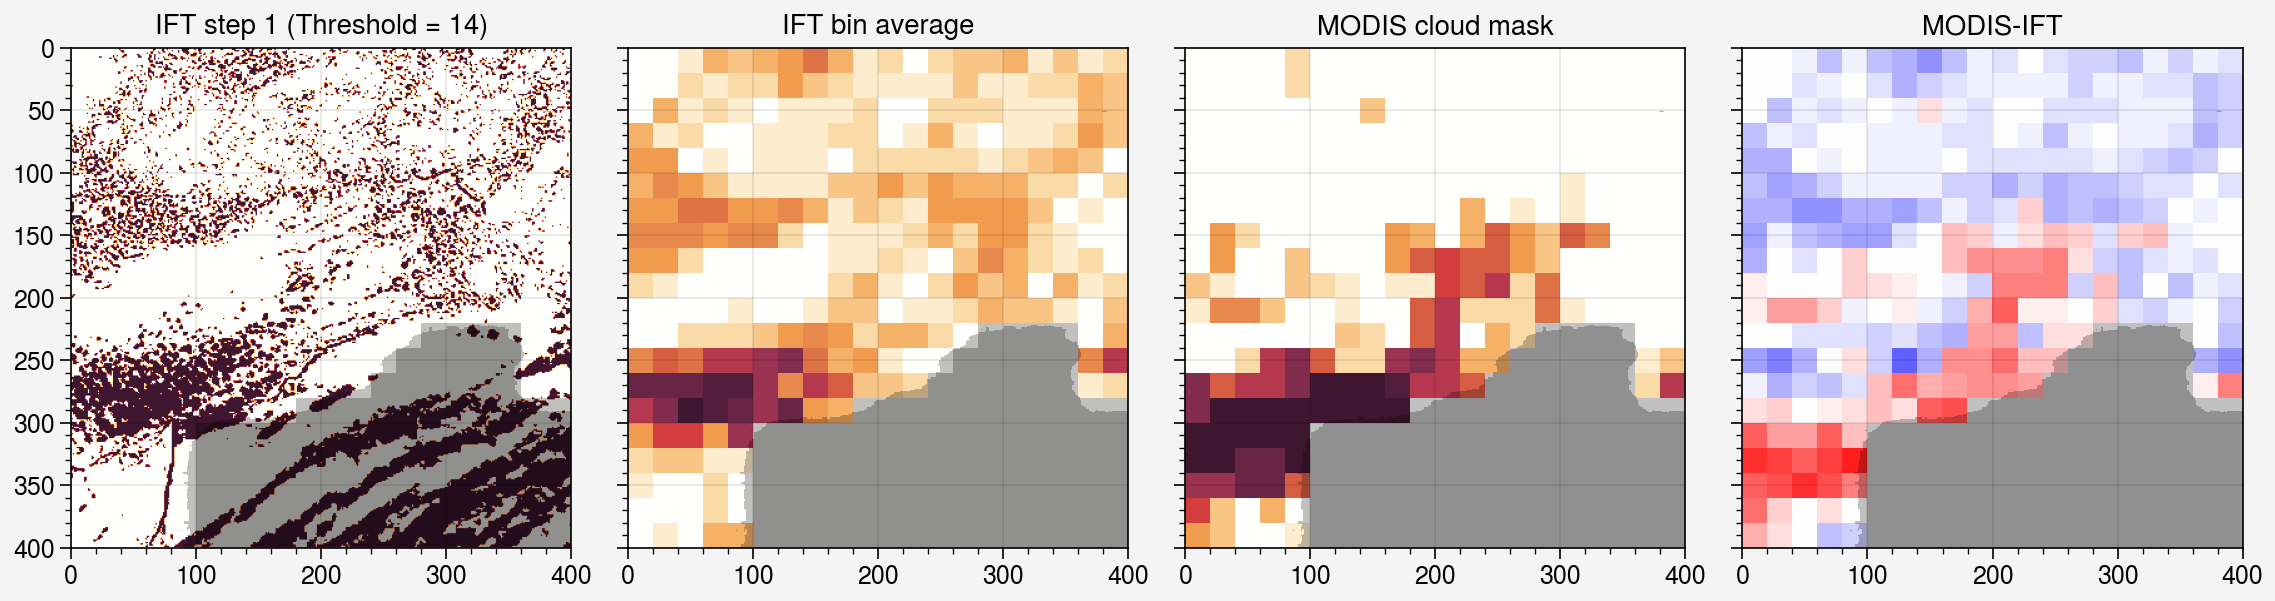

In [212]:
# assumes A is square! and that 20 evenly divdes the shape
case = '138_aqua'
tc = 14
ift_est = fc_images[case][0,:,:] > tc
land = lm_images[case].squeeze() > 0
A = ift_est.astype(int)
n = A.shape[0]
m = int(n/20)
# reshapes to dimension (80, 20, 80, 20)
Lmean = land.astype(int).reshape([m, n//m, m, n//m]).mean(3).mean(1)
Amean = A.reshape([m, n//m, m, n//m]).mean(3).mean(1)
Amean = np.ma.masked_array(Amean, mask=Lmean > 0.5)
bin_edges = np.linspace(0, 100, 17)
bin_centers = 0.5*(bin_edges[1:] + bin_edges[:-1])

ift_vec = np.ravel(Amean*100)
ift_dig = np.digitize(ift_vec, bin_edges) - 1 # Digitize puts 0 if less than the lowest bin, so you have to subtract.
ift_dig[ift_dig == 16] = 15 # Put values of exactly 100 into the highest bin
binned_ift = np.reshape(bin_centers[ift_dig], Amean.shape)
CF = np.ma.masked_array(cf_images[case].values[::20, ::20], mask=Lmean > 0.5)

fig, ax = pplt.subplots(ncols=4)
ax[0].imshow(A)
ax[1].imshow(binned_ift, extent=[0, 400, 400, 0])
ax[2].imshow(CF, extent=[0, 400, 400, 0])
ax[3].imshow(CF - binned_ift, vmin=-100, vmax=100, cmap='bwr',
            extent=[0, 400, 400, 0])
for ax0 in ax:
    ax0.imshow(np.ma.masked_array(land.astype(int), land==0), color='k', alpha=0.25, extent=[0, 400, 400, 0])
    ax0.imshow(np.ma.masked_array(Lmean, Lmean < 0.5), color='k', alpha=0.25, extent=[0, 400, 400, 0])
ax[0].format(title='IFT step 1 (Threshold = {tc})'.format(tc=tc))
ax[1].format(title='IFT bin average')
ax[2].format(title='MODIS cloud mask')
ax[3].format(title='MODIS-IFT')

In the figure, the original land mask is overlaid on the bin-averaged coarse mask for illustrative purposes.

## Comparison with MODIS cloud fraction (spatial resolving)
For each case, we compute the binned cloud fraction, matching the MODIS cloud fraction bins. Then we compute the mean square error between the two images.

In [180]:
def get_binned_ift_est(fc, tc_threshold):
    """Computes a 5 km average of the IFT data and bins it into the
    same resolution as the MODIS cloud fraction data."""
    ift_est = fc > tc_threshold
    
    A = ift_est.astype(int)
    n = A.shape[0]
    m = int(n/20)
    
    # reshapes to dimension (80, 20, 80, 20)
    Amean = A.reshape([m, n//m, m, n//m]).mean(3).mean(1)
    
    bin_edges = np.linspace(0, 100, 17)
    bin_centers = 0.5*(bin_edges[1:] + bin_edges[:-1])
    
    ift_vec = np.ravel(Amean*100)
    ift_dig = np.digitize(ift_vec, bin_edges) - 1 # Digitize puts 0 if less than the lowest bin, so you have to subtract.
    ift_dig[ift_dig == 16] = 15 # Put values of exactly 100 into the highest bin
    binned_ift = np.reshape(bin_centers[ift_dig], Amean.shape)

    return binned_ift

def get_binned_landmask(lm, lm_threshold=0.5):
    """Bins the land mask value and returns boolean array where True if land is greater than 50%"""
    L = (lm == 0).astype(int)
    n = L.shape[0]
    m = int(n/20)
    
    # reshapes to dimension (80, 20, 80, 20)
    Lmean = L.reshape([m, n//m, m, n//m]).mean(3).mean(1)
    return Lmean > lm_threshold

In [303]:
# Compute estimated cloud fraction for a range of threshold values
cloud_cases = df.index
TC = np.linspace(0, 200, 41)
df_err = pd.DataFrame(index=cloud_cases,
                          columns=TC, data=np.nan)

# for each value, compute an estimated cloud fraction based on the fc_images
for tc in df_err.columns:
    for case in df_err.index:
        if case in fc_images:
            ift_est = get_binned_ift_est(fc_images[case][0,:,:], tc)
            land = get_binned_landmask(lm_images[case][0,:,:], 0.5) # check whether I want this or its inverse
            mod_est = cf_images[case].values[::20,::20]
            difference = np.ma.masked_array(ift_est - mod_est, mask=land < 0.5)                
            df_err.loc[case, tc] = np.sqrt(np.mean((difference**2)))
df_training = df_err.loc[df['training']]
df_testing = df_err.loc[~df['training']] # only actually need the index here

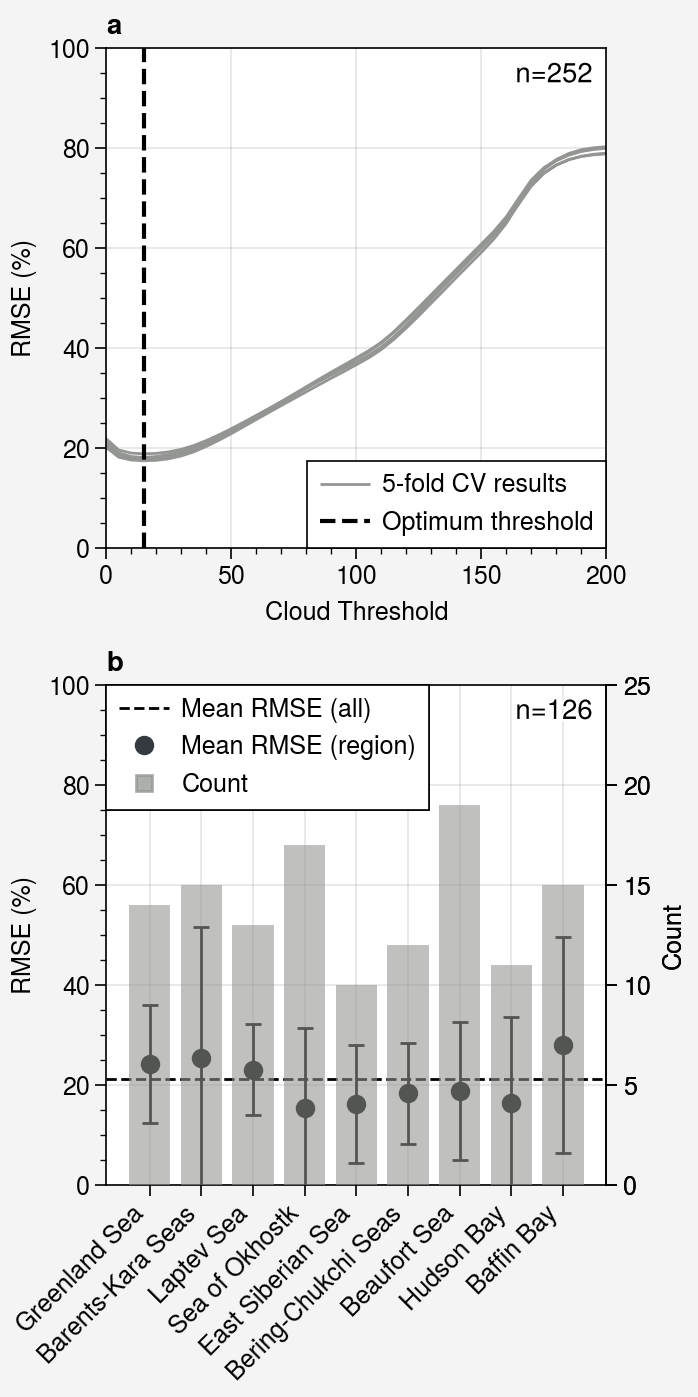

In [320]:
# Test version without splitting by regions to get syntax
fig, axs = pplt.subplots(nrows=2, share=False)

x_eval = np.linspace(TC.min(), TC.max(), 201)
results = []

kf = KFold(n_splits=5, random_state=20240126, shuffle=True)
ax = axs[0]
for i, (train_index, test_index) in enumerate(kf.split(df_training)):
    # first get the root mean square error as a function of TC
    rmse = np.mean(df_training.iloc[train_index,:], axis=0)
    
    # then find the minimum
    tc_optimal = pd.Series(interp1d(x=rmse.index, y=rmse.values, kind='quadratic')(x_eval), index=x_eval).idxmin()

    test_cases = df_training.iloc[test_index, :].index
    test_results = np.array([
        np.mean(fc_images[case][0,:,:] > tc_optimal) - df.loc[case, 'cloud_fraction_manual']
            for case in test_cases if case in fc_images])
    tc_rmse = np.sqrt(np.mean(test_results**2))
    results.append([tc_optimal, tc_rmse])
    
    ax.plot(rmse, label='', color='gray', lw=1) #label='k=' + str(i))


ax.plot([],[], color='gray', lw=1, label='5-fold CV results')
ax.format(ylim=(0, 100), urtitle='n=' + str(len(df_training)))
kfold_results = pd.DataFrame(results, columns=['TC', 'RMSE']).mean(axis=0).round(2)
tc = kfold_results['TC']

ax = axs[1]
test_results = pd.Series(np.nan, index=df_testing.index)
for case in test_results.index:
     ift_est = get_binned_ift_est(fc_images[case][0,:,:], tc)
     land = get_binned_landmask(lm_images[case][0,:,:], 0.5) # check whether I want this or its inverse
     mod_est = cf_images[case].values[::20,::20]
     difference = np.ma.masked_array(ift_est - mod_est, mask=land < 0.5)                
     test_results.loc[case] = np.sqrt(np.mean((difference**2)))

mean_rmse = test_results.groupby(df.loc[test_results.index, 'region']).mean()
stdev_rmse = test_results.groupby(df.loc[test_results.index, 'region']).std() 
ax.errorbar(x=np.arange(len(mean_rmse)),
    y=mean_rmse.values,
    yerr = stdev_rmse.values,
    marker='o', lw=0, zorder=2, color='k', elinewidth=1)
ax.axhline(test_results.mean(), color='k', ls='--', lw=1)
ax2 = ax.twinx()
region_counts = test_results.groupby(df.loc[test_results.index, 'region']).count()
region_counts = region_counts.loc[region_order]
region_counts.index =  [title_case[r] for r in region_counts.index]

ax2.bar(region_counts, zorder=0, color='gray', alpha=0.35
    )
ax2.format(ylabel='Count', ytickminor=False)

ax.format(xrotation=45, ylim=(0, 100), xlabel='', ylabel='RMSE')
ax.format(urtitle='n=' + str(len(test_results)))
ax2.format(ylim=(0, 25))
h = [ax.plot([],[],marker='', ls='--', color='k', lw=1),
     ax.plot([],[],marker='o', color='gray8', lw=0),
     ax.plot([],[],marker='s', color='gray', alpha=0.75, lw=0)]
ax2.legend(h, ['Mean RMSE (all)', 'Mean RMSE (region)', 'Count'], loc='ul', ncols=1, alpha=1)


# ax.axvline(110, color='k', label='Default threshold')
axs[0].axvline(kfold_results['TC'], color='k', ls='--', label='Optimum threshold')
axs[0].format(ylabel='RMSE (%)', xlabel='Cloud Threshold')
axs[1].format(ylabel='RMSE (%)')

axs[0].legend(loc='lr', ncols=1, alpha=1)
fig.format(abc=True)

fig.save('../figures/cloud_fraction_step1_calibration_modis.png', dpi=300)

In [306]:
kfold_results = pd.DataFrame(results, columns=['TC', 'RMSE'])
print('Cross validation results')
print(kfold_results.round(2))
print("\n")

tc, RMSE = kfold_results.mean(axis=0).round(2)
print('Training data')
print("Cloud threshold: ", int(tc))
print("RMSE (%): ", 100*RMSE)
print("\n")
# Error against the held-out data

print('Comparison against test data')
print('RMSE (%):', test_results.mean().round(2))

Cross validation results
     TC  RMSE
0  15.0  0.21
1  16.0  0.20
2  15.0  0.14
3  16.0  0.23
4  13.0  0.23


Training data
Cloud threshold:  15
RMSE (%):  20.0


Comparison against test data
RMSE (%): 22.4


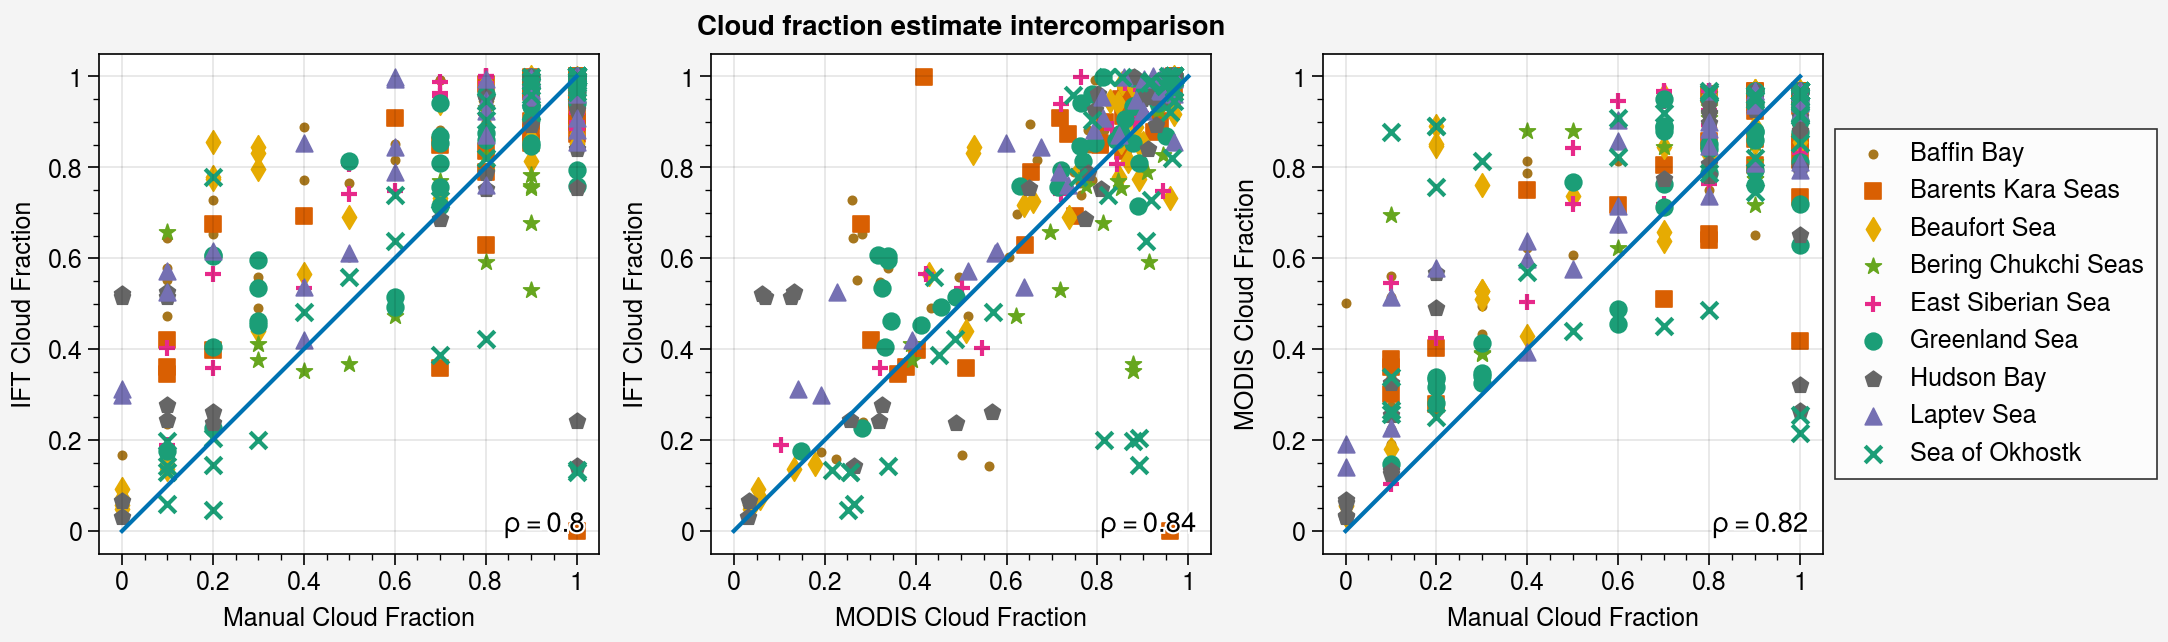

In [10]:
regions = pd.read_csv(dataloc + '/data/metadata/region_definitions.csv', index_col=0)

colors = {region: c['color'] for region, c in zip(
            regions.index,
            pplt.Cycle('dark2', len(regions)))}
markerstyles = {region: ls for region, ls in zip(regions.index,
                        ['o', 's', '^', '+', '*', 'd', '.', 'p', 'x'])}

regions['print_title'] = [c.replace('_', ' ').title().replace('Of', 'of') for c in regions.index]
regions = regions.sort_values('center_lon')
# Estimate from 
tc = 15
for case in fc_images:
    df.loc[case, 'ift_tc15_est'] = np.mean(fc_images[case][0,:,:] > tc)
    
fig, axs = pplt.subplots(ncols=3, share=False)
for ax, col in zip(axs, ['cloud_fraction_manual', 'cloud_fraction_modis']):
    for region, group in df.groupby('region'):
    
        ax.scatter(group[col], group['ift_tc15_est'], label=regions.loc[region, 'print_title'],
               m=markerstyles[region], color=colors[region])
    
    ax.plot([0, 1], [0, 1])
    ax.format(ylim=(-0.05, 1.05), xlim=(-0.05, 1.05),
          ylabel='IFT Cloud Fraction')
    ax.format(lrtitle='$\\rho=$' + str(np.round(df[col].corr(df['ift_tc15_est']), 2)))

axs[0].format(xlabel='Manual Cloud Fraction')
axs[1].format(xlabel='MODIS Cloud Fraction')

for region, group in df.groupby('region'):
    axs[2].scatter(group['cloud_fraction_manual'], group['cloud_fraction_modis'], label=regions.loc[region, 'print_title'],
               m=markerstyles[region], color=colors[region])
axs[2].plot([0, 1], [0, 1])
axs[2].format(ylim=(-0.05, 1.05), xlim=(-0.05, 1.05),
          ylabel='MODIS Cloud Fraction', xlabel='Manual Cloud Fraction')
axs[2].format(lrtitle='$\\rho=$' + str(np.round(df['cloud_fraction_manual'].corr(df['cloud_fraction_modis']), 2)))

axs[2].legend(loc='r', ncols=1)    

axs.format(suptitle='Cloud fraction estimate intercomparison')
fig.save('../figures/comparison_cloud_estimates.png', dpi=300)

# Pixel unmasking: identifying optically thin clouds
The original algorithm is
1. Mask all pixels with $l_1 > 110 = T_C$.
2. Unmask pixels with $l_1 < 200 = T_1$ and $l_2 > 190 = T_2$.
3. Unmask pixels with $l_1/l_2 < 0.75 = R_{1,2}$.

In the prior sections, we have found that the first step underestimates the total cloud cover (noting, however, that this high threshold was set just to mask the clouds with the highest opacity). To identify the thin clouds, we have three parameters to adjust, making the optimization a bit more challenging. 



Parameters to optimize over
1. $T_1$. Operates on channel 1.
2. $T_2$. Operates on channel 2.
3. $R_{1,2}$. Ratio of $T_1$ and $T_2$. Pixels with $R_{1,2}$ less than the threshold are unmasked.

This all connects via drawing a piecewise linear parametrized curve dividing cloud from non-cloud pixels.

In [11]:
def generate_masks(fc_image, t1, t2, r_lower, r_upper, tc):
    """Generate the all-cloud and opaque-cloud masks. Opaque cloud mask is defined as a subset
    of the all-cloud mask where the ice floes are visible."""
    clouds_view = fc_image[0,:,:] > tc # true == cloudy pixel
    mask_b7b2 = (fc_image[0,:,:] < t1) & (fc_image[1,:,:] > t2) # true == thin cloud
    mask_ratio = fc_image[0,:,:]/fc_image[1,:,:]
    mask_cloud_ice = (mask_ratio > r_lower) & (mask_ratio < r_upper)
    mask_cloud_ice = mask_cloud_ice & mask_b7b2
    cloud_mask = ~(mask_cloud_ice | ~clouds_view)
    return clouds_view, cloud_mask

The calibration in this section aims to minimize the reduction in the cloud mask while maximizing the fraction of manually-labeled ice floes that are uncovered. A big challenge here is that the images vary quite a bit in the number of ice floes. It is not obvious how we should weight the results, whether by pixels or what.

# Selecting reference regions for pixel thresholds
1. Using MASIE ice and land to find open water

TBD: 
* Assign test / train cases
* Check images with full cloud cover - any where the manual estimate especially disagrees? What threshold to use on cloud fraction for mask comparison?
* Identify cases where the cloud mask gets confused by the ice edge
* How to aggegrate? Do I fit a distribution?
* How should I report the cases where the mask should not have been removed?
* Should the B7/B2 ratio actually have a shift (e.g. (B7 + x)/(B2 + y) < ratio? Where should the line be drawn?
* All of this is really just using a piecewise linear threshold function.

# New approach: binning data by cloud/ice presence for plotting against 2D schematics

Next steps
1. Describe selection of pixels, cases
2. Make figure for publication with the histograms
3. Set up selection of b2, b7, ratio
4. Compute the confusion matrix

In [12]:
b7_ice_nocloud = []
b2_ice_nocloud = []
case_ice_nocloud = []

b7_ice_cloud = []
b2_ice_cloud = []
case_ice_cloud = []

b7_cloud = []
b2_cloud = []
case_cloud = []

count = 0
min_cloud_frac = 20
for row, data in df.iterrows():
    case = '{cn}_{s}'.format(cn=data.case_number, s=data.satellite)
    b7 = fc_images[case][0,:,:]
    b2 = fc_images[case][1,:,:]
    # get boolean masks for each of these
    modis_cloud = cf_images[case] > min_cloud_frac
    land = np.sum(lm_images[case], axis=0) > 1 # replace with boolean mask in the end
    
    if case in lb_images:
        if data.floe_obscuration in ['none', 'light']:
            ice_floes = lb_images[case][0,:,:] > 0
            fast_ice = lf_images[case][0,:,:] > 0
            ice_nocloud_pixels = (ice_floes | fast_ice) & ~modis_cloud
            ice_cloud_pixels = (ice_floes | fast_ice) & modis_cloud                
            
            b7_ice_nocloud.append(b7[ice_nocloud_pixels])
            b2_ice_nocloud.append(b2[ice_nocloud_pixels])
            case_ice_nocloud.append([case] * ice_nocloud_pixels.astype(int).sum().sum())
            
            b7_ice_cloud.append(b7[ice_cloud_pixels])
            b2_ice_cloud.append(b2[ice_cloud_pixels])
            case_ice_cloud.append([case] * ice_cloud_pixels.astype(int).sum().sum())
            
    if data.visible_sea_ice == 'no':
        if data.visible_landfast_ice == 'no':
            if data.cloud_category_manual == 'opaque':
                cloud_pixels = modis_cloud & ~land
                b7_cloud.append(b7[cloud_pixels])
                b2_cloud.append(b2[cloud_pixels])
                
                case_cloud.append([case] * cloud_pixels.astype(int).sum().sum())
    else:
        if data.cloud_category_manual == 'opaque':
            if case in lb_images:
                no_ice = ~(ice_floes | fast_ice)
                cloud_pixels = no_ice & modis_cloud & ~land
                b7_cloud.append(b7[cloud_pixels])
                b2_cloud.append(b2[cloud_pixels])
                case_cloud.append([case] * cloud_pixels.astype(int).sum().sum())
                
b7_ice_nocloud = np.hstack(b7_ice_nocloud)
b2_ice_nocloud = np.hstack(b2_ice_nocloud)
case_ice_nocloud = np.hstack(case_ice_nocloud)

b7_ice_cloud = np.hstack(b7_ice_cloud)
b2_ice_cloud = np.hstack(b2_ice_cloud)
case_ice_cloud = np.hstack(case_ice_cloud)

b7_cloud = np.hstack(b7_cloud)
b2_cloud = np.hstack(b2_cloud)    
case_cloud = np.hstack(case_cloud)

In [13]:
def cloud_mask(b2, b7, t0=110, t_b7=200, t_b2=190, t_b7b2=0.75):
    step_1 = b7 > t0
    step_2 = b7 < b2*t_b7b2
    step_3 = (b7 < t_b7) & (b2 > t_b2)
    return step_1 & ~(step_2 | step_3)

In [16]:
# Make dataframes
clear_ice = pd.DataFrame({'case': case_ice_nocloud, 'b7': b7_ice_nocloud, 'b2': b2_ice_nocloud, 'training': df.loc[case_ice_nocloud, 'training'].values})
cloudy_ice = pd.DataFrame({'case': case_ice_cloud, 'b7': b7_ice_cloud, 'b2': b2_ice_cloud, 'training': df.loc[case_ice_cloud, 'training'].values})
cloudy = pd.DataFrame({'case': case_cloud, 'b7': b7_cloud, 'b2': b2_cloud, 'training': df.loc[case_cloud, 'training'].values})

In [17]:
print('Number of pixels (thousands)')
for title, data in zip(['B7 Clearsky Ice', 'B2 Clearsky Ice', 'B7 Cloudy Ice', 'B2 Cloudy Ice', 'B7 Cloud', 'B2 Cloud'],
                       [clear_ice['b7'], clear_ice['b2'], cloudy_ice['b7'], cloudy_ice['b2'], cloudy['b7'], cloudy['b2']]):
    print(title, int(np.round(len(data)/1e3, 0)))

Number of pixels (thousands)
B7 Clearsky Ice 897
B2 Clearsky Ice 897
B7 Cloudy Ice 655
B2 Cloudy Ice 655
B7 Cloud 11904
B2 Cloud 11904


In [336]:
def get_thresholds(b2_threshold, b2_data, b7_data, method='quantile'):
    """Starting from a proposed b2 threshold, estimate thresholds for b7
    and for the b7/b2 ratio based on the distribution of b2_data and b7_data."""

    b7_idx = (b2_data > b2_threshold) & (b7_data > 5)
    r_idx = ((b2_data > 0) & (b2_data <= b2_threshold)) & (b7_data > 5)
    if method == 'quantile':    
        r = b7_data[r_idx] / b2_data[r_idx]
        b7b2_threshold = np.round(np.quantile(r, 0.99), 2)
        b7_threshold = np.quantile(b7_data[b7_idx], 0.99)
        if b7_threshold < b2_threshold * b7b2_threshold:
            b7_threshold = b2_threshold * b7b2_threshold
        
        return (b7_threshold, b7b2_threshold)
        
    elif method == 'iqr_outlier':
        b7_median = np.median(b7_data[b7_idx])
        b7_iqr = np.diff(np.quantile(b7_data[b7_idx], [0.25, 0.75])).squeeze()
        b7_threshold = b7_median + 1.5*b7_iqr

        # b7_subset = b7_data[b2_data <= b2_threshold]
        # b2_subset = b2_data[b2_data <= b2_threshold]
        r = b7_data[r_idx] / b2_data[r_idx]
        # r = r[(r > 0) & (r < 1e3)]
        r_median = np.median(r)
        r_iqr = np.diff(np.quantile(r, [0.25, 0.75])).squeeze()
        b7b2_threshold = np.round(r_median + 1.5*r_iqr, 2)
        return b7_threshold, b7b2_threshold
        
def compute_error(tau_init, tau_b2, tau_b7, tau_b7b2, b2_data, b7_data):
    """Computes the fraction of cloud-covered ice pixels labeled as clear"""
    idx = b7_data >= tau_init
    idx = idx & ~((tau_b2 < b2_data) & (tau_b7 > b7_data))
    idx = idx & (b7_data / b2_data > tau_b7b2)
    return(1-np.sum(idx)/len(idx))

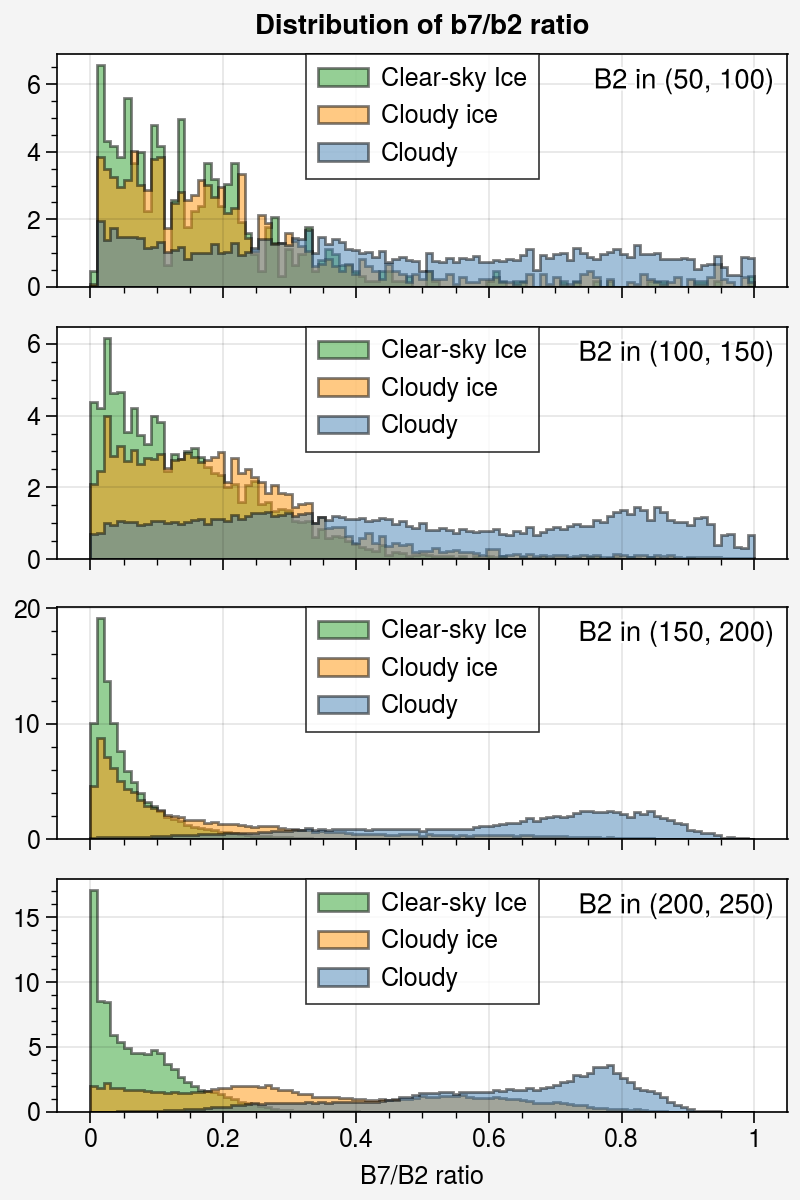

In [19]:
fig, axs = pplt.subplots(width=4, height=6, nrows=4)
b2_data = b2_ice_cloud
b7_data = b7_ice_cloud
for ax, bandstart in zip(axs, np.arange(50, 201, 50)):
    for b2_data, b7_data, label, color in zip([clear_ice.loc[clear_ice.training, 'b2'], cloudy_ice.loc[cloudy_ice.training, 'b2'], cloudy.loc[cloudy.training, 'b2']],
                                       [clear_ice.loc[clear_ice.training, 'b7'], cloudy_ice.loc[cloudy_ice.training, 'b7'], cloudy.loc[cloudy.training, 'b7']],
                                       ['Clear-sky Ice', 'Cloudy ice', 'Cloudy'],
                                       ['tab:green', 'tangerine', 'steelblue']):
        idx = (b2_data > bandstart) & (b2_data <= bandstart + 50)
        idx = idx & (b2_data > 0)
        idx = idx & (b7_data > 0)
        if np.sum(idx) > 1e2:
            _ = ax.hist(b7_data[idx] / b2_data[idx], bins=np.linspace(0, 1, 100), alpha=0.5,
                    density=True, fill=True, ec='k', label=label, lw=1, color=color)
    ax.format(urtitle='B2 in ({b0}, {b1})'.format(b0=bandstart, b1=bandstart + 50))
    ax.legend(ncols=1, loc='uc')
axs.format(suptitle='Distribution of b7/b2 ratio', xlabel='B7/B2 ratio')
fig.save('../figures/b7b2_ratio_histograms.png', dpi=300)

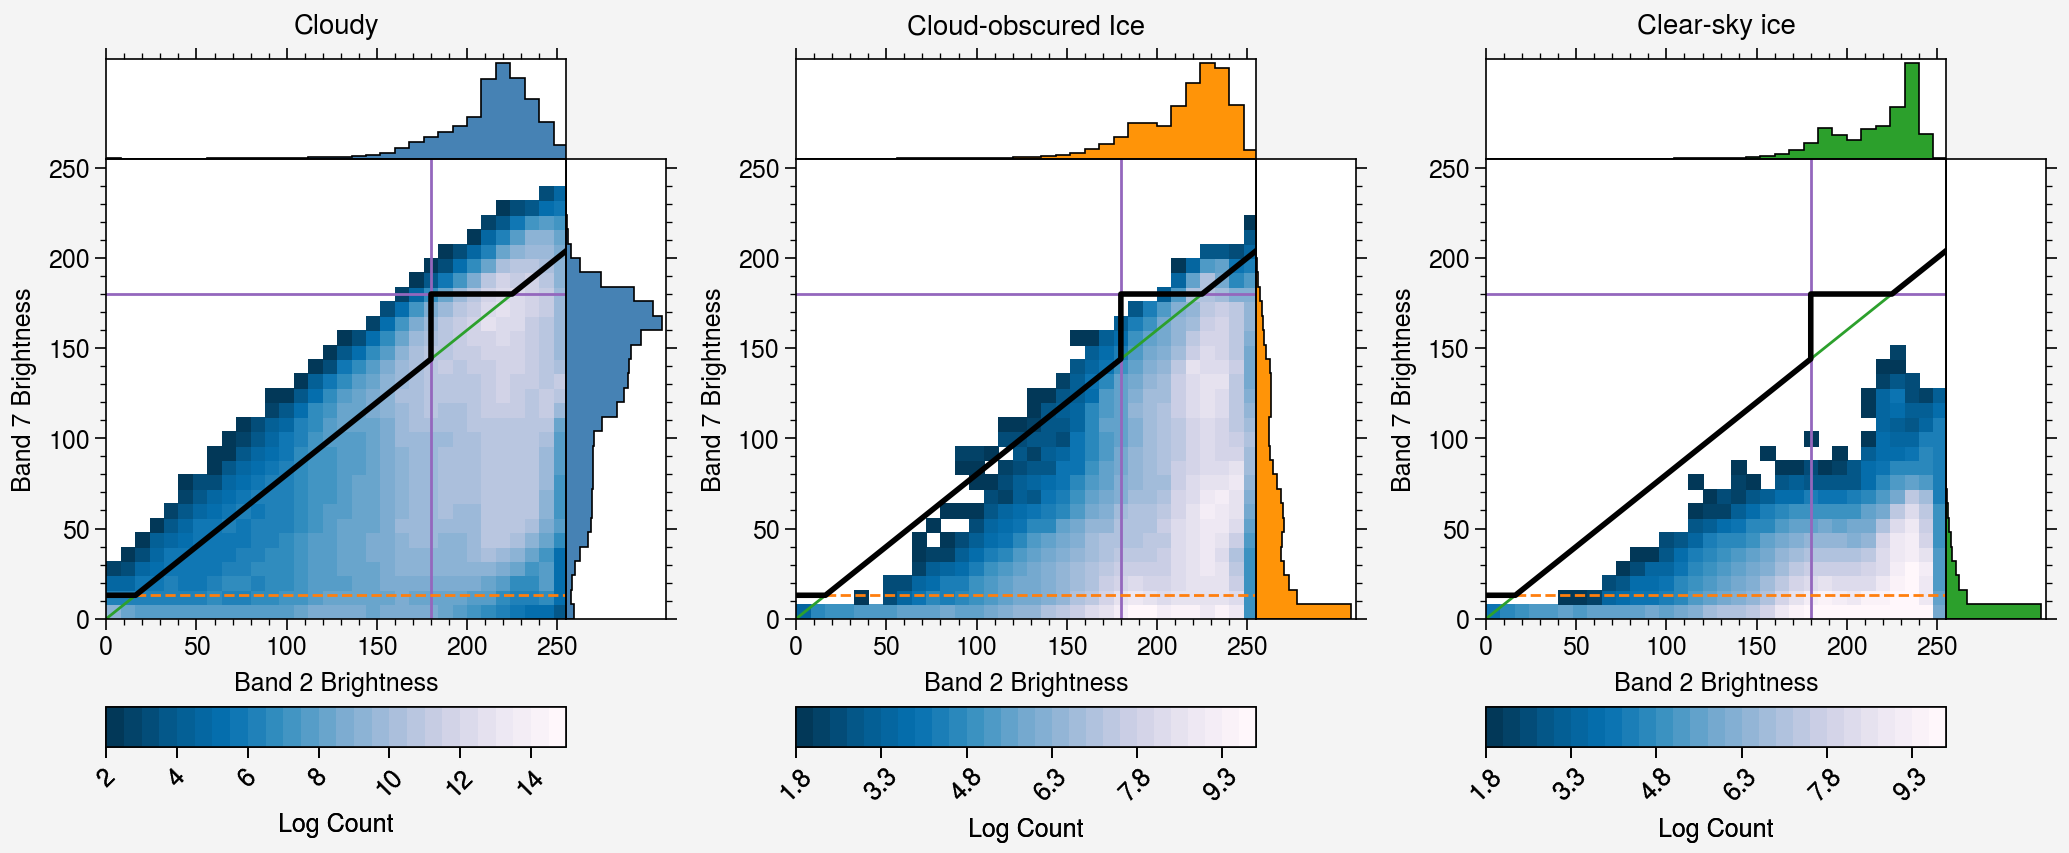

In [338]:
import proplot as pplt
import numpy as np

# Histogram with marginal distributions
fig, axs = pplt.subplots(ncols=3, refwidth=2.3, share=False)

# can loop this with some care
ax = axs[0]

ax.format(titleabove=True,
    title='Cloudy'
)

color = 'steelblue'
x = b2_cloud.copy()
y = b7_cloud.copy()

bins = np.linspace(0, 256, 33)
binc = 0.5*(bins[1:] + bins[:-1])
H, _, _ = np.histogram2d(x, y, bins=[bins, bins])
H = H.T
ax.pcolormesh(binc, binc, np.log(np.ma.masked_array(H, H <= 5)),
              vmin=np.log(5), vmax=15, levels=30,
              cmap='PuBu_r', colorbar='b', colorbar_kw={'label': 'Log Count', 'rotation': 45})

# color = pplt.scale_luminance(color, 1.5)  # histogram colors
px = ax.panel('r', space=0)
px.histh(y, bins, color=color, fill=True, ec='k')
px.format(grid=False, xlocator=[], ylabel='Band 7 Brightness', xreverse=False)

px = ax.panel('t', space=0)
px.hist(x, bins, color=color, fill=True, ec='k')
px.format(grid=False, ylocator=[])

ax = axs[1]
color = 'tangerine'
x = b2_ice_cloud.copy()
y = b7_ice_cloud.copy()
ax.format(titleabove=True,
    title='Cloud-obscured Ice'
)

H, _, _ = np.histogram2d(x, y, bins=[bins, bins])
H = H.T
ax.pcolormesh(binc, binc, np.log(np.ma.masked_array(H, H <= 5)),
              vmin=np.log(5), vmax=10, levels=30,
              cmap='PuBu_r', colorbar='b', colorbar_kw={'label': 'Log Count', 'rotation': 45})

# color = pplt.scale_luminance(color, 1.5)  # histogram colors
px = ax.panel('r', space=0)
px.histh(y, bins, color=color, fill=True, ec='k')
px.format(grid=False, xlocator=[], ylabel='Band 7 Brightness', xreverse=False)

px = ax.panel('t', space=0)
px.hist(x, bins, color=color, fill=True, ec='k')
px.format(grid=False, ylocator=[])
axs.format(ylim=(0, 255), xlim=(0, 255))

x = b2_ice_nocloud.copy()
y = b7_ice_nocloud.copy()
ax = axs[2]
color='tab:green'
ax.format(titleabove=True,
    title='Clear-sky ice'
)

H, _, _ = np.histogram2d(x, y, bins=[bins, bins])
H = H.T
ax.pcolormesh(binc, binc, np.log(np.ma.masked_array(H, H <= 5)),
              vmin=np.log(5), vmax=10, levels=30,
              cmap='PuBu_r', colorbar='b', colorbar_kw={'label': 'Log Count', 'rotation': 45})

px = ax.panel('r', space=0)
px.histh(y, bins, color=color, fill=True, ec='k')
px.format(grid=False, xlocator=[], ylabel='Band 7 Brightness', xreverse=False)

px = ax.panel('t', space=0)
px.hist(x, bins, color=color, fill=True, ec='k')
px.format(grid=False, ylocator=[])
axs.format(ylim=(0, 255), xlim=(0, 255), xlabel='Band 2 Brightness')

fig.save('../figures/cloud_mask_histograms.png', dpi=300)

tau_init = 13
tau_b2 = 180
tau_b7 = 180
tau_b7b2 = 0.8
for ax in axs:
    ax.axhline(tau_b7, ls='-', label='B7 < tau_7', lw=1, color='tab:purple')
    ax.axvline(tau_b2, ls='-', label='B2 < tau_2', lw=1, color='tab:purple')
    ax.axhline(tau_init, ls='--', label='B7 > tau_0', lw=1, color='tab:orange')
    ax.plot([0, 255], [0, tau_b7b2*255], color='tab:green', lw=1)
    
    # draw solid line 
    # This version is if the crossing is above the line and the b7/b2 threshold continues
    ax.plot([0, tau_init/tau_b7b2, tau_b2, tau_b2, tau_b7/tau_b7b2, 256],
            [tau_init, tau_init, tau_b2*tau_b7b2, tau_b7, tau_b7, 256*tau_b7b2], color='k', lw=2)

fig.save('../figures/cloud_mask_histograms_alt_lines2.png', dpi=300)

Parameter sweep:

In [44]:
cloud_mask??

Signature: cloud_mask(b2, b7, t0=110, t_b7=200, t_b2=190, t_b7b2=0.75)
Docstring: <no docstring>
Source:   
def cloud_mask(b2, b7, t0=110, t_b7=200, t_b2=190, t_b7b2=0.75):
    step_1 = b7 > t0
    step_2 = b7 < b2*t_b7b2
    step_3 = (b7 < t_b7) & (b2 > t_b2)
    return step_1 & ~(step_2 | step_3)
File:      /var/folders/_1/dv6d0pjn20bgy9ysl0pfsbr40000gn/T/ipykernel_47756/1309427152.py
Type:      function

In [78]:
%%time
training_data = pd.concat([cloudy_ice[cloudy_ice['training']], clear_ice[clear_ice['training']]])
training_data['b7b2'] = training_data['b7']/training_data['b2'].where(training_data['b2'] > 50)
training_data = training_data.dropna()
sweep_results = []
for b2_threshold in np.arange(100, 225, 10):
    
    ice_pix = training_data.loc[(training_data['b2'] <= b2_threshold) & (training_data['b2'] > 50)]
    if len(ice_pix) > 1000:
        for R_threshold in np.arange(0.1, 1, 0.1):
            b7_min = R_threshold*b2_threshold
            if b7_min <= 200:
                for b7_threshold in np.arange(round(b7_min), 225, 10):
                    fp = cloud_mask(training_data['b2'], training_data['b7'], t0=15,
                                    t_b7=b7_threshold, t_b2=b2_threshold, t_b7b2=R_threshold)
                    tp = cloud_mask(cloudy.loc[cloudy.training, 'b2'], cloudy.loc[cloudy.training, 'b7'],
                                   t_b7=b7_threshold, t_b2=b2_threshold, t_b7b2=R_threshold)
                    F1 = 2*np.sum(tp)/(2*np.sum(tp) + np.sum(fp) + np.sum(~tp))
                    sweep_results.append([b2_threshold, R_threshold, b7_threshold, np.round(F1, 2)])

CPU times: user 2min 43s, sys: 39.5 s, total: 3min 22s
Wall time: 3min 23s


In [75]:
b7_threshold = 100
b2_threshold = 200
R_threshold = 0.5
fp = cloud_mask(training_data['b2'], training_data['b7'], t0=15,
                t_b7=b7_threshold, t_b2=b2_threshold, t_b7b2=R_threshold)
tp = cloud_mask(cloudy.loc[cloudy.training, 'b2'], cloudy.loc[cloudy.training, 'b7'],
               t_b7=b7_threshold, t_b2=b2_threshold, t_b7b2=R_threshold)
F1 = 2*np.sum(tp)/(2*np.sum(tp) + np.sum(fp) + np.sum(~tp))

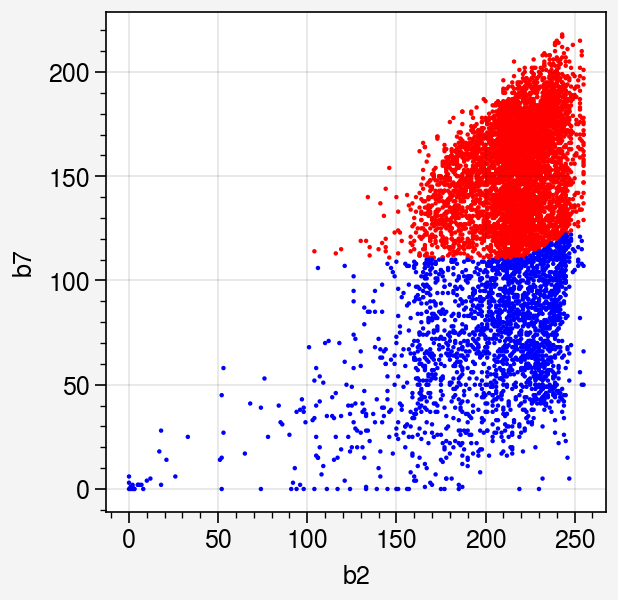

In [76]:
fig, ax = pplt.subplots()
ax.scatter(cloudy.loc[cloudy.training, 'b2'][::1000], cloudy.loc[cloudy.training, 'b7'][::1000],
           c=tp.astype(int)[::1000], cmap='bwr', ms=1)

The f1 score is the harmonic mean of the precision and the recall. In this case, we are considering pixels that have known values of "cloudy" or "ice". We've pooled together the clear-sky and the cloudy ice. The exhaustive parameter search using the f1 score lets us simultaneously vary each of the settings, though there's not much sensitivity in any cases where the b2 and b7 intersection is less than R. 

In [54]:
sweep_results = pd.DataFrame(sweep_results, columns=['b2', 'R', 'b7', 'f1'])

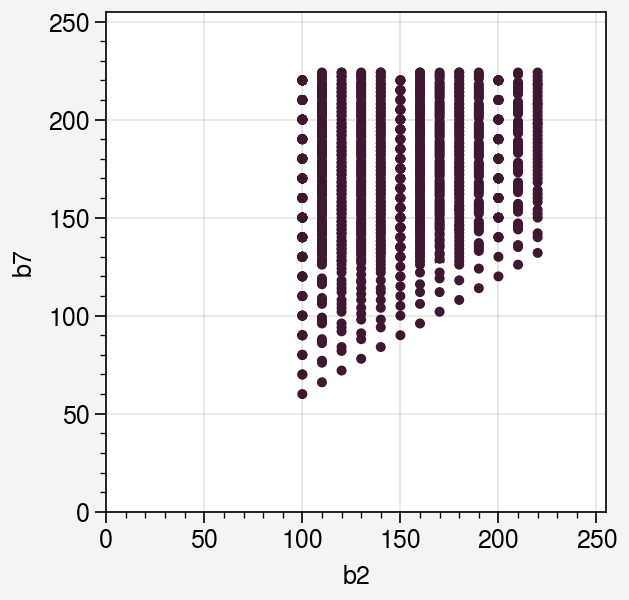

In [63]:
fig, ax = pplt.subplots()
ax.scatter(sweep_results['b2'], sweep_results['b7'], marker='.', c=sweep_results['f1'])
ax.format(ylim=(0, 255), xlim=(0, 255))

In [ ]:
print('Default settings')
clouds = cloud_mask(b2_cloud, b7_cloud)
print('Cloud pixels covered: ', np.round(np.mean(clouds), 2)*100, '%')
icecloud = cloud_mask(b2_ice_cloud, b7_ice_cloud)
print('Cloud-obscured ice pixels covered: ', np.round(np.mean(icecloud), 2)*100, '%')
ice = cloud_mask(b2_ice_nocloud, b7_ice_nocloud)
print('Ice pixels covered: ', np.round(np.mean(ice), 2)*100, '%')

In [ ]:
tau_init = 13
tau_b2 = 180
tau_b7 = 180
tau_b7b2 = 0.8
print('Fit mask vs cloud-covered ice')
clouds = cloud_mask(b2_cloud, b7_cloud, t0=tau_init, t_b7=tau_b7, t_b2=tau_b2, t_b7b2=tau_b7b2)
print('Cloud pixels covered: ', np.round(np.mean(clouds), 2)*100, '%')
icecloud = cloud_mask(b2_ice_cloud, b7_ice_cloud, t0=tau_init, t_b7=tau_b7, t_b2=tau_b2, t_b7b2=tau_b7b2)
print('Cloud-obscured ice pixels covered: ', np.round(np.mean(icecloud), 2)*100, '%')
ice = cloud_mask(b2_ice_nocloud, b7_ice_nocloud, t0=tau_init, t_b7=tau_b7, t_b2=tau_b2, t_b7b2=tau_b7b2)
print('Ice pixels covered: ', np.round(np.mean(ice), 2)*100, '%')

In [ ]:
tau_init = 13
tau_b2 = 180
tau_b7 = 80
tau_b7b2 = 0.4
print('Fit mask vs clear-sky ice')
clouds = cloud_mask(b2_cloud, b7_cloud, t0=tau_init, t_b7=tau_b7, t_b2=tau_b2, t_b7b2=tau_b7b2)
print('Cloud pixels covered: ', np.round(np.mean(clouds), 2)*100, '%')
icecloud = cloud_mask(b2_ice_cloud, b7_ice_cloud, t0=tau_init, t_b7=tau_b7, t_b2=tau_b2, t_b7b2=tau_b7b2)
print('Cloud-obscured ice pixels covered: ', np.round(np.mean(icecloud), 2)*100, '%')
ice = cloud_mask(b2_ice_nocloud, b7_ice_nocloud, t0=tau_init, t_b7=tau_b7, t_b2=tau_b2, t_b7b2=tau_b7b2)
print('Ice pixels covered: ', np.round(np.mean(ice), 2)*100, '%')

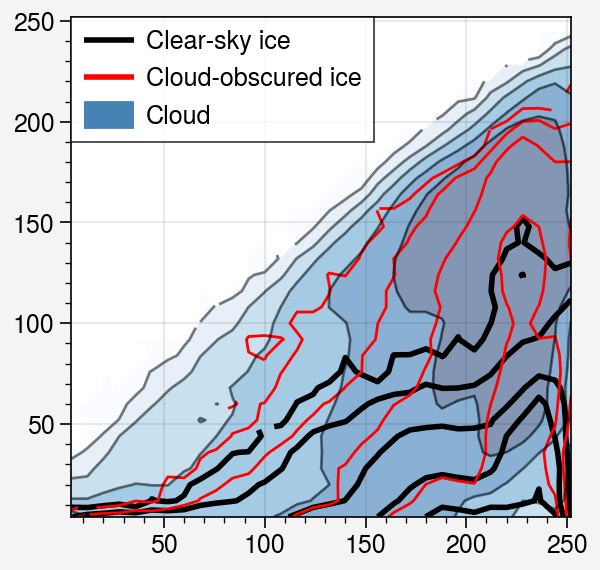

In [339]:
fig, ax = pplt.subplots()
bins = np.linspace(0, 256, 33)
binc = 0.5*(bins[1:] + bins[:-1])
H, _, _ = np.histogram2d(b2_ice_nocloud, b7_ice_nocloud, bins=[bins, bins])
H = H.T
ax.contour(binc, binc, np.log(np.ma.masked_array(H, H == 0)),
              vmin=np.log(5), vmax=10, levels=5, lw=2,
              c='k')


H, _, _ = np.histogram2d(b2_ice_cloud, b7_ice_cloud, bins=[bins, bins])
H = H.T
ax.contour(binc, binc, np.log(np.ma.masked_array(H, H == 0)),
              vmin=np.log(5), vmax=10, levels=5, lw=1,
              c='r')

H, _, _ = np.histogram2d(b2_cloud, b7_cloud, bins=[bins, bins])
H = H.T
ax.contourf(binc, binc, np.log(np.ma.masked_array(H, H == 0)),
              vmin=np.log(5), vmax=10, levels=5, lw=1,
              cmap='blues', extend='both', alpha=0.5)

h = [ax.plot([],[],ls='-', c='k', lw=2),
     ax.plot([],[],ls='-', c='r', lw=2),
     ax.plot([],[],ls='-', c='steelblue', lw=10)]
ax.legend(h, ['Clear-sky ice', 'Cloud-obscured ice', 'Cloud'], ncols=1, loc='ul')
 

# Example image

# Strategies to estimate the parameters for the cloud mask
What defines a good set of parameters?
1. Pixels known to have sea ice are not masked.
2. As many cloudy pixels are masked as possible.
3. If possible without strongly degrading the cloud mask, allow cloud-covered sea ice pixels to be unmasked.

Method one: quantile-based
1. Use the clear sky sea ice pixels as a reference.
2. Specify a Band 2 threshold.
3. Set the ratio threshold = 99th percentile of B7/B2 for the pixels with B2 <= threshold
4. Set the band 7 threshold as the 99th percentile for the set of pixels with B2 > threshold. If below the ratio * B2, set to ratio * B2.

Method two: 
1. Use the clear sky sea ice pixels as a reference.
2. Specify a Band 2 threshold.
3. Calculate the B7/B2 ratio threshold based on 1.5 $\times$ IQR for pixels with B2 < threshold.
4. Calculate B7 threshold based on 1.5 $\times$ IQR for pixels with B2 > threshold. If below ratio * B2, set to ratio * B2.

Method three:
1. Specify a Band 2 threshold.
2. Find the value of the ratio that solves a max-min for covering as much of the cloud as possible with as little of the ice as possible.


In [ ]:
tau_b2 = 180
get_thresholds(tau_b2, b2_ice_nocloud, b7_ice_nocloud, method='quantile')

In [ ]:
get_thresholds(tau_b2, b2_ice_nocloud, b7_ice_nocloud, method='iqr_outlier')

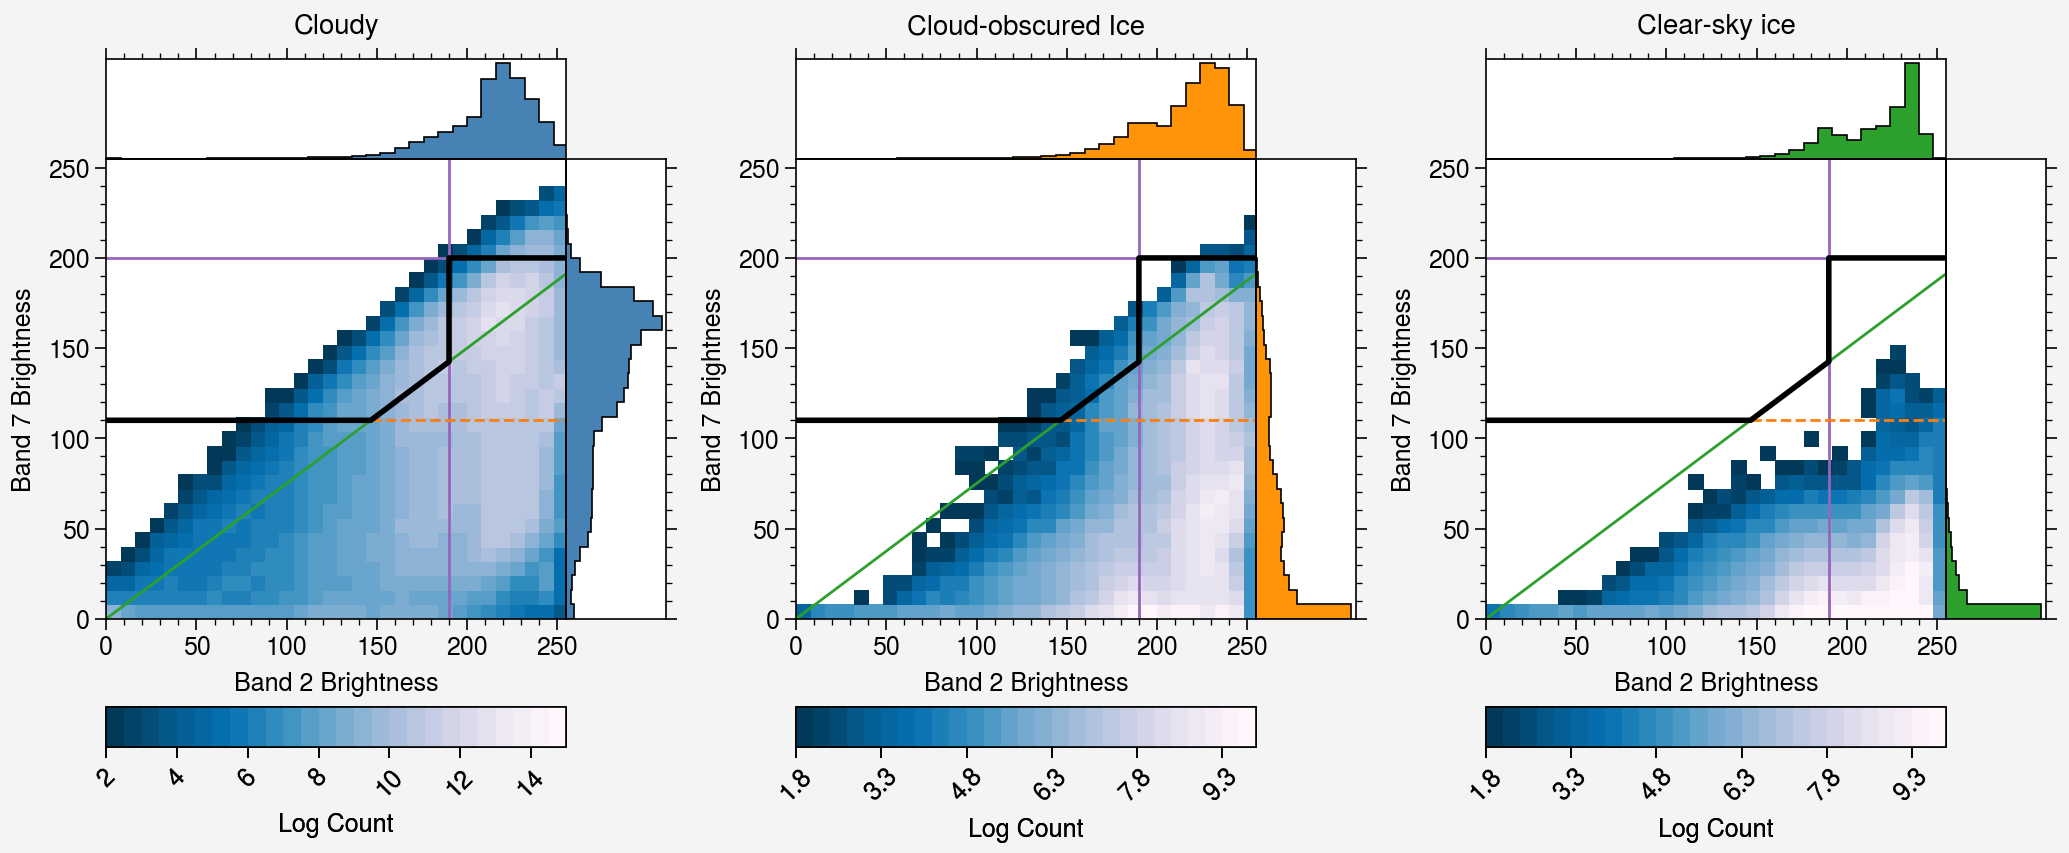

In [340]:
import proplot as pplt
import numpy as np

# Histogram with marginal distributions
fig, axs = pplt.subplots(ncols=3, refwidth=2.3, share=False)

# can loop this with some care
ax = axs[0]

ax.format(titleabove=True,
    title='Cloudy'
)

color = 'steelblue'
x = b2_cloud.copy()
y = b7_cloud.copy()

bins = np.linspace(0, 256, 33)
binc = 0.5*(bins[1:] + bins[:-1])
H, _, _ = np.histogram2d(x, y, bins=[bins, bins])
H = H.T
ax.pcolormesh(binc, binc, np.log(np.ma.masked_array(H, H <= 5)),
              vmin=np.log(5), vmax=15, levels=30,
              cmap='PuBu_r', colorbar='b', colorbar_kw={'label': 'Log Count', 'rotation': 45})

# color = pplt.scale_luminance(color, 1.5)  # histogram colors
px = ax.panel('r', space=0)
px.histh(y, bins, color=color, fill=True, ec='k')
px.format(grid=False, xlocator=[], ylabel='Band 7 Brightness', xreverse=False)

px = ax.panel('t', space=0)
px.hist(x, bins, color=color, fill=True, ec='k')
px.format(grid=False, ylocator=[])

ax = axs[1]
color = 'tangerine'
x = b2_ice_cloud.copy()
y = b7_ice_cloud.copy()
ax.format(titleabove=True,
    title='Cloud-obscured Ice'
)

H, _, _ = np.histogram2d(x, y, bins=[bins, bins])
H = H.T
ax.pcolormesh(binc, binc, np.log(np.ma.masked_array(H, H <= 5)),
              vmin=np.log(5), vmax=10, levels=30,
              cmap='PuBu_r', colorbar='b', colorbar_kw={'label': 'Log Count', 'rotation': 45})

# color = pplt.scale_luminance(color, 1.5)  # histogram colors
px = ax.panel('r', space=0)
px.histh(y, bins, color=color, fill=True, ec='k')
px.format(grid=False, xlocator=[], ylabel='Band 7 Brightness', xreverse=False)

px = ax.panel('t', space=0)
px.hist(x, bins, color=color, fill=True, ec='k')
px.format(grid=False, ylocator=[])
axs.format(ylim=(0, 255), xlim=(0, 255))

x = b2_ice_nocloud.copy()
y = b7_ice_nocloud.copy()
ax = axs[2]
color='tab:green'
ax.format(titleabove=True,
    title='Clear-sky ice'
)

H, _, _ = np.histogram2d(x, y, bins=[bins, bins])
H = H.T
ax.pcolormesh(binc, binc, np.log(np.ma.masked_array(H, H <= 5)),
              vmin=np.log(5), vmax=10, levels=30,
              cmap='PuBu_r', colorbar='b', colorbar_kw={'label': 'Log Count', 'rotation': 45})

px = ax.panel('r', space=0)
px.histh(y, bins, color=color, fill=True, ec='k')
px.format(grid=False, xlocator=[], ylabel='Band 7 Brightness', xreverse=False)

px = ax.panel('t', space=0)
px.hist(x, bins, color=color, fill=True, ec='k')
px.format(grid=False, ylocator=[])
axs.format(ylim=(0, 255), xlim=(0, 255), xlabel='Band 2 Brightness')

fig.save('../figures/cloud_mask_histograms.png', dpi=300)

tau_init = 110
tau_b2 = 190
tau_b7 = 200
tau_b7b2 = 0.75
for ax in axs:
    ax.axhline(tau_b7, ls='-', label='B7 < tau_7', lw=1, color='tab:purple')
    ax.axvline(tau_b2, ls='-', label='B2 < tau_2', lw=1, color='tab:purple')
    ax.axhline(tau_init, ls='--', label='B7 > tau_0', lw=1, color='tab:orange')
    ax.plot([0, 255], [0, tau_b7b2*255], color='tab:green', lw=1)

    
    # draw solid line
    ax.plot([0, tau_init/tau_b7b2, tau_b2, tau_b2, 256],
            [tau_init, tau_init, tau_b2*tau_b7b2, tau_b7, tau_b7], color='k', lw=2)

fig.save('../figures/cloud_mask_histograms_default_lines.png', dpi=300)




In [ ]:
# Range for the b2_ice_nocloud case:
# Less than 1% of the ice data has b2 less than 118 or greater than 246
# 95% of the data is between 162 and 242. 
np.quantile(b2_ice_nocloud, [0.005, 0.995])
np.quantile(b2_ice_nocloud, [0.025, 0.975])

In [ ]:
candidate_b2 = np.arange(150, 250, 5)
nocloud_results = []
for tau_b2 in candidate_b2:
    tau_b7, tau_b7b2 = get_thresholds(tau_b2, b2_ice_nocloud, b7_ice_nocloud, method='quantile')
    tau_init, tau_b2, tau_b7, tau_b7b2

    cloud_err = compute_error(tau_init, tau_b2, tau_b7, tau_b7b2, b2_cloud, b7_cloud)
    ice_cloud_err = 1-compute_error(tau_init, tau_b2, tau_b7, tau_b7b2, b2_ice_cloud, b7_ice_cloud)
    ice_err = 1-compute_error(tau_init, tau_b2, tau_b7, tau_b7b2, b2_ice_nocloud, b7_ice_nocloud)
    nocloud_results.append([tau_b2, tau_b7, tau_b7b2, cloud_err, ice_cloud_err, ice_err])
nocloud_results = pd.DataFrame(nocloud_results, columns=['tau_b2', 'tau_b7', 'tau_b7b2', 'cloud_err', 'ice_cloud_err', 'ice_err'])

candidate_b2 = np.arange(150, 250, 5)
icecloud_results = []
for tau_b2 in candidate_b2:
    tau_b7, tau_b7b2 = get_thresholds(tau_b2, b2_ice_cloud, b7_ice_cloud,  method='quantile')

    cloud_err = compute_error(tau_init, tau_b2, tau_b7, tau_b7b2, b2_cloud, b7_cloud)
    ice_cloud_err = 1-compute_error(tau_init, tau_b2, tau_b7, tau_b7b2, b2_ice_cloud, b7_ice_cloud)
    ice_err = 1-compute_error(tau_init, tau_b2, tau_b7, tau_b7b2, b2_ice_nocloud, b7_ice_nocloud)
    icecloud_results.append([tau_b2, tau_b7, tau_b7b2, cloud_err, ice_cloud_err, ice_err])
icecloud_results = pd.DataFrame(icecloud_results, columns=['tau_b2', 'tau_b7', 'tau_b7b2', 'cloud_err', 'ice_cloud_err', 'ice_err'])

In [ ]:
nocloud_results['cross_below_ratio'] = nocloud_results['tau_b7']/nocloud_results['tau_b2'] < nocloud_results['tau_b7b2']
icecloud_results['cross_below_ratio'] = icecloud_results['tau_b7']/icecloud_results['tau_b2'] < icecloud_results['tau_b7b2']

In [ ]:
nocloud_results

In [ ]:
compute_error(110, 200, 190, 0.75, b2_cloud, b7_cloud)

In [ ]:
1 - compute_error(110, 200, 190, 0.75, b2_ice_nocloud, b7_ice_nocloud)

In [ ]:
fig, ax = pplt.subplots()
ax.plot(nocloud_results['tau_b2'].values,
        nocloud_results['cloud_err'].values, label='Cloud Error', c='b')
ax.plot(nocloud_results['tau_b2'].values, nocloud_results['ice_cloud_err'].values,
        label='Cloudy Ice Error', c='r')
ax.plot(nocloud_results['tau_b2'].values, nocloud_results['ice_err'].values,
        label='Ice Error', c='k')

ax.plot(icecloud_results['tau_b2'].values, icecloud_results['cloud_err'].values,
        label='Cloud Error (cloudy ice)', c='b', ls='--')
ax.plot(icecloud_results['tau_b2'].values, icecloud_results['ice_cloud_err'].values,
        label='Cloudy Ice Error (cloudy ice)', c='r', ls='--')
ax.plot(icecloud_results['tau_b2'].values, icecloud_results['ice_err'].values,
        label='Ice Error (cloudy ice)', c='k', ls='--')
ax.legend(loc='r', ncols=1)
ax.format(ylim=(0, 1))

In [ ]:
fig, axs = pplt.subplots(ncols=1)
# Init clouds
ax = axs[0]
X = np.zeros((255, 255))
for ii in range(255): # y axis 
    for jj in range(255): # x axis
        set1 = jj > 110
        set2 = (ii > 190) & (jj < 200)
        set3 = jj/(ii + 0.001) < 0.75
        if set1 & ~(set2 | set3):
            X[ii, jj] = 1
ax.pcolormesh(np.arange(255), np.arange(255), np.ma.masked_array(X.T, X.T==0), alpha=0.5, c='r')
ax.axvline(190, ls='-', lw=1, color='tab:purple')
ax.axhline(200, ls='-', label='B2 < tau_2', lw=1, color='tab:purple')
ax.axhline(110, ls='--', label='B7 > tau_0', lw=1, color='tab:orange')
ax.plot([0, 255], [0, 0.75*255], color='tab:green', lw=1)
ax.format(title='Original mask', ylabel='B$_7$ Corrected Reflectance', xlabel='B$_2$ Corrected Reflectance')
fig.save('../figures/init_mask_schematic.png', dpi=300)

In [ ]:
tau_b7, tau_b7b2 = get_thresholds(tau_b2, b2_ice_nocloud, b7_ice_nocloud,  method='quantile')


In [ ]:
fig, axs = pplt.subplots(ncols=2)
# Init clouds
ax = axs[0]
X = np.zeros((255, 255))
for ii in range(255): # y axis 
    for jj in range(255): # x axis
        set1 = jj > 110
        set2 = (ii > 190) & (jj < 200)
        set3 = jj/(ii + 0.001) < 0.75
        if set1 & ~(set2 | set3):
            X[ii, jj] = 1
ax.pcolormesh(np.arange(255), np.arange(255), np.ma.masked_array(X.T, X.T==0), alpha=0.5, c='r')
ax.axvline(190, ls='-', lw=1, color='tab:purple')
ax.axhline(200, ls='-', label='B2 < tau_2', lw=1, color='tab:purple')
ax.axhline(110, ls='--', label='B7 > tau_0', lw=1, color='tab:orange')
ax.plot([0, 255], [0, 0.75*255], color='tab:green', lw=1)
ax.format(title='Original mask', ylabel='B7 Pixel Intensity', xlabel='B2 Pixel Intensity')

ax = axs[1]
tau_init = 13
tau_b2 = 180
tau_b7, tau_b7b2 = get_thresholds(tau_b2, b2_ice_nocloud, b7_ice_nocloud,  method='quantile')
print(tau_b2, tau_b7, tau_b7b2)
X = np.zeros((255, 255))
for ii in range(255): # y axis 
    for jj in range(255): # x axis
        set1 = jj > tau_init
        set2 = (ii > tau_b2) & (jj < tau_b7)
        set3 = jj/(ii + 0.001) < tau_b7b2
        if set1 & ~(set2 | set3):
            X[ii, jj] = 1

bins = np.linspace(0, 256, 33)
binc = 0.5*(bins[1:] + bins[:-1])
H, _, _ = np.histogram2d(b2_ice_cloud, b7_ice_cloud, bins=[bins, bins])
H = H.T
for ax in axs:
    ax.contour(binc, binc, np.log(np.ma.masked_array(H, H == 0)),
              vmin=np.log(5), vmax=10, levels=5, lw=2,
              c='k')

H, _, _ = np.histogram2d(b2_cloud, b7_cloud, bins=[bins, bins])
H = H.T
for ax in axs:
    ax.contour(binc, binc, np.log(np.ma.masked_array(H, H == 0)),
              vmin=np.log(5), vmax=10, levels=5, lw=1,
              c='b')


ax.pcolormesh(np.arange(255), np.arange(255), np.ma.masked_array(X.T, X.T==0), alpha=0.25, c='b')
ax.axvline(tau_b2, ls='-', label='B7 < tau_7', lw=1, color='tab:purple')
ax.axhline(tau_b7, ls='-', label='B2 < tau_2', lw=1, color='tab:purple')
ax.axhline(tau_init, ls='--', label='B7 > tau_0', lw=1, color='tab:orange')
ax.format(title='Updated mask')
ax.plot([0, 255], [0, tau_b7b2*255], color='tab:green', lw=1)

In [ ]:
fig, ax = pplt.subplots()
bins = np.linspace(0, 256, 33)
binc = 0.5*(bins[1:] + bins[:-1])
H, _, _ = np.histogram2d(b2_ice_nocloud, b7_ice_nocloud, bins=[bins, bins])
H = H.T
ax.contour(binc, binc, np.log(np.ma.masked_array(H, H == 0)),
              vmin=np.log(5), vmax=10, levels=5, lw=2,
              c='k')


H, _, _ = np.histogram2d(b2_ice_cloud, b7_ice_cloud, bins=[bins, bins])
H = H.T
ax.contour(binc, binc, np.log(np.ma.masked_array(H, H == 0)),
              vmin=np.log(5), vmax=10, levels=5, lw=1,
              c='r')

H, _, _ = np.histogram2d(b2_cloud, b7_cloud, bins=[bins, bins])
H = H.T
ax.contourf(binc, binc, np.log(np.ma.masked_array(H, H == 0)),
              vmin=np.log(5), vmax=10, levels=5, lw=1,
              cmap='blues', extend='both', alpha=0.5)

h = [ax.plot([],[],ls='-', c='k', lw=2),
     ax.plot([],[],ls='-', c='r', lw=2),
     ax.plot([],[],ls='-', c='steelblue', lw=10)]
ax.legend(h, ['Clear-sky ice', 'Cloud-obscured ice', 'Cloud'], ncols=1, loc='ul')
 

## Surprising but not hard to interpret results
1. The clear-sky sea ice pixels essentially always come through just fine
2. We get nearly as good results just using the ratio
3. We can include more cloud-covered ice by adding the bump, but that comes at a cost
4. Need to check other methods for getting the lines, perhaps based on getting the per

In [ ]:
tau_b7, tau_b7b2 = get_thresholds(tau_b2, b2_ice_cloud, b7_ice_cloud,  method='quantile')
print(tau_b2, tau_b7, tau_b7b2)

In [ ]:
import skimage

case = '056_aqua'

region = df.loc[case,'region']
cf_manual = (df.loc[case, 'cloud_fraction_manual']*100).round(0)
cf_modis = (df.loc[case, 'cloud_fraction_modis']*100).round(0)

fig, axs = pplt.subplots(ncols=3, nrows=2)

# first few images have a single array
clouds_view_init, cloud_mask_init = generate_masks(fc_images[case], t1=200, t2=190,
                                                   r_lower=0, r_upper=0.75, tc=110)
layered_mask_init = ((cloud_mask_init).astype(float) + clouds_view_init.astype(float))/2

clouds_view_new, cloud_mask_new = generate_masks(fc_images[case], t1=180, t2=80, r_lower=0, r_upper=0.4, tc=13)
layered_mask_new = ((cloud_mask_new).astype(float) + clouds_view_new.astype(float))/2

for ax, data, title in zip(axs, 
                [tc_images[case], fc_images[case], cf_images[case], layered_mask_init, layered_mask_new],
                ['TC Image', 'FC Image', 'Cloud Fraction (%)', 'Default Cloud Mask', 'Updated Cloud Mask']):
    if title in ['TC Image', 'FC Image']:
        ax.imshow(reshape_as_image(data))
    elif title == 'Cloud Fraction (%)':
        c = ax.pcolormesh(data.values, vmin=0, vmax=100, N=17, cmap='Blues')
        ax.colorbar(c, label='Cloud Fraction (%)')
        ax.format(urtitle='Manual: {c0}%\nModis: {c1}'.format(c0=cf_manual, c1=cf_modis))
    elif 'Mask' in title:
        c = ax.pcolormesh(data, N=3, cmap='blues')
        ax.colorbar(c, ticks=[.2, 0.6, 1], loc='b', alpha=1, ticklabels=['Clear', 'Unmask', 'Mask'], ticklen=0.1)
        manual_floe_labels = lb_images[case][0,:,:] % 2
        outlines = manual_floe_labels - skimage.morphology.erosion(manual_floe_labels, skimage.morphology.disk(4))
        ax.pcolormesh(np.ma.masked_array(outlines, outlines==0), color='r', alpha=0.5)

    ax.format(title=title, yreverse=True)





# # plot MASIE data
# ax = axs[1, 1]
# masie_ice = mi_images[case].squeeze()
# masie_land = ml_images[case].squeeze()
# ax.imshow(np.ma.masked_array(masie_land, mask=masie_land != 1), c='steelblue')
# ax.imshow(np.ma.masked_array(masie_ice, mask=masie_ice==0), c='w')
# ax.imshow(np.ma.masked_array(masie_land, mask=masie_land != 2), c='gray')
# ax.imshow(np.ma.masked_array(masie_land, mask=masie_land != 4), c='darkgray')
# h = []
# for c in ['steelblue', 'w', 'lightgray', 'darkgray']:
#     h.append(ax.plot([],[],m='s', lw=0, c=c, edgecolor='k'))
# ax.legend(h, ['Water', 'Ice', 'Coast', 'Land'], loc='b', ncols=2)
# ax.format(title='MASIE')


# plot manual label data
ax = axs[1, 2]
binary_land = lm_images[case][0,:,:]
clouds25 = (cf_images[case] >= 25).astype(int)
clouds50 = (cf_images[case] >= 50).astype(int)
clouds = (clouds25 + clouds50)/2

ax.imshow(np.ma.masked_array(binary_land, mask=binary_land == 0), c='gray9')
if case in lb_images:
    manual_ice = lb_images[case][0,:,:]
    ax.imshow(np.ma.masked_array(manual_ice, mask=manual_ice==0), c='red5')
else:
    ax.format(ultitle='No ice mask')
    
if case in lf_images:
    manual_landfast = lf_images[case][0,:,:]
    ax.imshow(np.ma.masked_array(manual_landfast, mask=manual_landfast == 0), c='yellow4')
else:
    ax.format(urtitle='No landfast mask')

ax.imshow(np.ma.masked_array(clouds, mask=clouds==0), cmap='Blues', vmin=0, vmax=2, alpha=0.5)
    
h = []
for c in ['red5', 'yellow4', 'darkgray', 'lightblue']:
    h.append(ax.plot([],[],m='s', lw=0, c=c, edgecolor='k'))
ax.legend(h, ['Sea Ice', 'Landfast Ice', 'Land', 'MODIS cloud'], loc='b', ncols=2)
ax.format(title='Manual labels')

axs.format(yreverse=True, suptitle=case.replace('_', ' ') + ' ' + region.replace('_', ' ').title())
# fig.save('../figures/overview_images/' + case + '_' + region + '_overview.png', dpi=300)

In [ ]:
print("B7 percentiles: 95, 99, 99.9%")
print("Cloud:   ", np.quantile(b7_cloud, [0.95, 0.99, 0.999]))
print("IceCld:  ", np.quantile(b7_ice_cloud, [0.95, 0.99, 0.999]))
print("IceNoCld:", np.quantile(b7_ice_nocloud, [0.95, 0.99, 0.999]))

In [ ]:
print("B7 percentiles: 95, 99, 99.9%")
print("Cloud:   ", np.quantile(b2_cloud, [0.95, 0.99, 0.999]))
print("IceCld:  ", np.quantile(b2_ice_cloud, [0.95, 0.99, 0.999]))
print("IceNoCld:", np.quantile(b2_ice_nocloud, [0.95, 0.99, 0.999]))

In [ ]:
fig, ax = pplt.subplots()
r = b7_ice_nocloud / b2_ice_nocloud
r = r[b2_ice_nocloud < 210]
r = r[r > 0]
r = r[r < 10e5]
_ = ax.hist(r, bins=np.linspace(0, 1, 50), alpha=0.5, density=True)

r = b7_ice_cloud / b2_ice_cloud
r = r[b2_ice_cloud < 210]
r = r[r > 0]
r = r[r < 10e5]
_ = ax.hist(r, bins=np.linspace(0, 1, 50), alpha=0.5, density=True)

r = b7_cloud / b2_cloud
r = r[b2_cloud < 210]
r = r[r > 0]
r = r[r < 10e5]
_ = ax.hist(r, bins=np.linspace(0, 1, 50), alpha=0.5, density=True)

Some takeaways:
- I'll need to define a tolerance for weighing the performance with the position of each line. How much is acceptable to miss in each category?
- The cloud category has a pretty major overlap with the ice-cloud category. How can I make sure that I'm not including the cases where there are not-yet-labeled ice floes? Or clearly visible ice?
- What kind of penalty should there be for uncovering regions where no visible sea ice is there?

# Evaluating best choices for ratios
We can use the manually labeled dataset to identify thresholds and/or breakpoints. Many images are essentially 100% opaque clouds (though to be fair some of those may include sea ice with no visible floes. We'll need to select a training and testing portion of the dataset. I think the final mask should also be cleaned up so that objects smaller than, say 100 pixels, are removed from the mask. 

1. Clouds
   1. Cloud fraction > 80%
   2. Cloud type = Opaque
   3. No visible sea ice
2. Sea ice floes, clear skies
   1. Cloud fraction < 0.2
   2. Visible floes -- verify manually
   3. Compute average of estimated cloud fraction within floe
3. Sea ice floes, cloud-obscured
   1. Visible floes
   2. Cloud type thin
   3. Compte average of estimated cloud fraction within floe
4. Open water
   1. Use the MASIE ice fraction and the landmask / 

* definitely clouds
  * opaque clouds, higher than 90% cloud cover
* definitely open water
* maybe one of those but it's unclear

Ratio B7 to B2: this is the ratio of band 7 to band 1. 
- Pixels with water tend to be dark, and have higher values of the threshold.
- Pixels with snow and ice tend to have low ratios.

NSDII2: a normalized ratio of bands 4 and 2 (band 4 = 0.55, band 2 = 0.84). Band 7 is 2.1, Band 1 is 0.65, Band 3=0.46

One description of NDSI is (R1 - R2)/(R1 + R2), where R1 is visible and R2 is shortwave infrared. So in the initial modis algorithm, they'd used band 4 for R1, and used band 6 for R2, but that band is missing in Aqua. So 

Conditions 1-2: pretty good for separating ice and water, but not perfect


`


In [ ]:
df.loc[(df.cloud_fraction_manual > 0.8) & (df.visible_sea_ice=='no')]

In [ ]:
case = "048_aqua"
# clouds_view = fc_images[case][0,:,:] > tc # true == cloudy pixel
b4 = tc_images[case][1,:,:]
b7 = fc_images[case][0,:,:]
b2 = fc_images[case][1,:,:]

nsdii2 = (b4 - b2)/(b4 + b2)
mask_ratio = b7/b2
floes = np.ravel(lb_images[case])
nsdii2_data = np.ravel(nsdii2)
nsdii2_data = nsdii2_data[~np.isnan(nsdii2_data)]
nsdii2_data = nsdii2_data[nsdii2_data <= 2]

ratio_data = np.ravel(mask_ratio)
ratio_data = ratio_data[~np.isnan(ratio_data)]
ratio_data = ratio_data[ratio_data <= 2]

nsdi = (b2 - b7)/(b2 + b7) # alternative from VIIRS paper
nsdi_data = np.ravel(nsdi)
nsdi_data = nsdi_data[~np.isnan(nsdi_data)]
nsdi_data = nsdi_data[nsdi_data <= 2]


fig, ax = pplt.subplots(width=5, height=3)
_ = ax.hist(nsdii2_data, bins=np.linspace(0, 2, 100), alpha=0.5, label='NSDII2')
_ = ax.hist(ratio_data, bins=np.linspace(0, 2, 100), alpha=0.5, label='B7/B2')
_ = ax.hist(nsdi_data, bins=np.linspace(0, 2, 100), alpha=0.5, label='NSDI_alt')

ax.legend(ncols=1)

In [ ]:
# 
case = "048_aqua"
# clouds_view = fc_images[case][0,:,:] > tc # true == cloudy pixel
b4 = tc_images[case][1,:,:]
b7 = fc_images[case][0,:,:]
b2 = fc_images[case][1,:,:]

nsdii2 = (b4 - b2)/(b4 + b2)
mask_ratio = b7/b2
floes = np.ravel(lb_images[case])
nsdii2_data = np.ravel(nsdii2)
nsdii2_data = nsdii2_data[~np.isnan(nsdii2_data)]
nsdii2_data = nsdii2_data[nsdii2_data <= 2]

ratio_data = np.ravel(mask_ratio)
ratio_data = ratio_data[~np.isnan(ratio_data)]
ratio_data = ratio_data[ratio_data <= 2]

fig, ax = pplt.subplots(width=5, height=3)
_ = ax.hist(nsdii2_data, bins=np.linspace(0, 2, 100), alpha=0.5, label='NSDII2')
_ = ax.hist(ratio_data, bins=np.linspace(0, 2, 100), alpha=0.5, label='B7/B2')
ax.legend(ncols=1)

In [ ]:
fig, ax = pplt.subplots()
ax.scatter(np.ravel(mask_ratio), np.ravel(nsdii2), ms=1, m='.', alpha=0.1)
ax.format(ylim=(0, 10), xlim=(0, 10), xscale='log', yscale='log')

# Alternative approach
We can look for the range of brightnesses that are observed for ice floes that are under clouds.  The thresholds should be grounded in reality in a sense at least. We can do a sweep and average across many cases, but would it be as effective? 

* We don't want a threshold so high that raising it simply increases the error in cloud cover.
* Similarly for too low.
* In between, we may want to optimize.

In [ ]:
nearly_full_cloud_cover = df.loc[df.visible_sea_ice=='no'].index
fig, ax = pplt.subplots(ncols=3, sharex=False, sharey=False)
all_cloudy = []
all_clear = []
for case in nearly_full_cloud_cover:
    if case in cf_images:
        if fc_images[case].shape[1] == 400:
            brightness = np.ravel(fc_images[case][0,:,:])
            cloudy = np.ravel(cf_images[case]) > 80
            clear = np.ravel(cf_images[case]) <= 80
            all_cloudy.append(brightness[cloudy])
            all_clear.append(brightness[clear])
all_clear = np.hstack(all_clear)
all_cloudy = np.hstack(all_cloudy)
print('fc1', 'clear', np.median(all_clear))
print('fc1', 'cloudy', np.median(all_cloudy))
ax[0].hist(all_clear, alpha=0.5, label='Clear skies', bins=np.linspace(0, 255, 40))
ax[0].hist(all_cloudy, alpha=0.5, label='Cloudy', bins=np.linspace(0, 255, 40))
ax[0].axvline(110, label='$\\tau_c = 110$', color='k', ls='-', lw=1)
ax[0].axvline(14, label='$\\tau_c = 14$', color='k', ls='-.', lw=1)
ax[0].axvline(200, label='$\\tau_1 = 200$', color='k', ls='--', lw=1)
ax[0].format(title='FC Channel 1', xlabel='Brightness')
ax[0].legend(ncols=1, alpha=1)

all_cloudy = []
all_clear = []
for case in nearly_full_cloud_cover:
    if case in cf_images:
        if fc_images[case].shape[1] == 400:
            brightness = np.ravel(fc_images[case][1,:,:])
            cloudy = np.ravel(cf_images[case]) > 80
            clear = np.ravel(cf_images[case]) <= 80
            all_cloudy.append(brightness[cloudy])
            all_clear.append(brightness[clear])
all_cloudy = np.hstack(all_cloudy)
all_clear = np.hstack(all_clear)
print('fc2', 'clear', np.median(all_cloudy))
print('fc2', 'cloudy', np.median(all_clear))

ax[1].hist(all_clear, alpha=0.5, label='Clear skies', bins=np.linspace(0, 255, 40))
ax[1].hist(all_cloudy, alpha=0.5, label='Cloudy', bins=np.linspace(0, 255, 40))
ax[1].axvline(190, label='$\\tau_2 = 110$', color='k', ls='--', lw=1)
ax[1].format(title='FC Channel 2', xlabel='Brightness')
ax[1].legend(ncols=1, alpha=1)

all_cloudy = []
all_clear = []
for case in nearly_full_cloud_cover:
    if case in cf_images:
        if fc_images[case].shape[1] == 400:
            brightness = np.ravel(fc_images[case][0,:,:]) / np.ravel(fc_images[case][1,:,:])
            cloudy = np.ravel(cf_images[case]) > 80
            clear = np.ravel(cf_images[case]) <= 80
            all_cloudy.append(brightness[cloudy])
            all_clear.append(brightness[clear])

r = np.hstack(all_clear)
r = r[(r >= 0) & (r <= 1)]
print('fc1/fc2', 'clear', np.median(r))
ax[2].hist(r, alpha=0.5, label='Clear skies', bins=np.linspace(0, 1, 30))

r = np.hstack(all_cloudy)
r = r[(r >= 0) & (r <= 1)]
print('fc1/fc2', 'cloudy', np.median(r))
ax[2].hist(r, alpha=0.5, label='Clear skies', bins=np.linspace(0, 1, 30))


In [ ]:
fig, ax = pplt.subplots(ncols=3, sharex=False, sharey=False)
sea_ice_cloudy = []
sea_ice_clear = []
for case in lb_images:
    if lb_images[case].shape[1] == 400:
        brightness = np.ravel(fc_images[case][0,:,:])
        cloudy = np.ravel(cf_images[case]) > 80
        sea_ice = np.ravel(lb_images[case][0,:,:]) > 0
        sea_ice_cloudy.append(brightness[cloudy & sea_ice])
        sea_ice_clear.append(brightness[~cloudy & sea_ice])
sea_ice_clear = np.hstack(sea_ice_clear)
sea_ice_cloudy = np.hstack(sea_ice_cloudy)
print('fc1', 'clear', np.median(sea_ice_clear))
print('fc1', 'cloudy', np.median(sea_ice_cloudy))
ax[0].hist(np.hstack(sea_ice_clear), alpha=0.5, label='Clear skies', bins=np.linspace(0, 255, 40))
ax[0].hist(np.hstack(sea_ice_cloudy), alpha=0.5, label='Cloudy', bins=np.linspace(0, 255, 40))
ax[0].axvline(110, label='$\\tau_c = 110$', color='k', ls='-', lw=1)
ax[0].axvline(14, label='$\\tau_c = 14$', color='k', ls='-.', lw=1)
ax[0].axvline(200, label='$\\tau_1 = 200$', color='k', ls='--', lw=1)
ax[0].format(title='FC Channel 1', xlabel='Brightness')
ax[0].legend(ncols=1, alpha=1)

sea_ice_cloudy = []
sea_ice_clear = []
for case in lb_images:
    if lb_images[case].shape[1] == 400:
        brightness = np.ravel(fc_images[case][1,:,:])
        cloudy = np.ravel(cf_images[case]) > 80
        sea_ice = np.ravel(lb_images[case][0,:,:]) > 0
        sea_ice_cloudy.append(brightness[cloudy & sea_ice])
        sea_ice_clear.append(brightness[~cloudy & sea_ice])
sea_ice_clear = np.hstack(sea_ice_clear)
sea_ice_cloudy = np.hstack(sea_ice_cloudy)
print('fc2', 'clear', np.median(sea_ice_clear))
print('fc2', 'cloudy', np.median(sea_ice_cloudy))

ax[1].hist(np.hstack(sea_ice_clear), alpha=0.5, label='Clear skies', bins=np.linspace(0, 255, 40))
ax[1].hist(np.hstack(sea_ice_cloudy), alpha=0.5, label='Cloudy', bins=np.linspace(0, 255, 40))
ax[1].axvline(190, label='$\\tau_2 = 110$', color='k', ls='--', lw=1)
ax[1].format(title='FC Channel 2', xlabel='Brightness')
ax[1].legend(ncols=1, alpha=1)

sea_ice_cloudy = []
sea_ice_clear = []
for case in lb_images:
    if lb_images[case].shape[1] == 400:
        brightness = np.ravel(fc_images[case][0,:,:]) / np.ravel(fc_images[case][1,:,:])
        cloudy = np.ravel(cf_images[case]) > 80
        sea_ice = np.ravel(lb_images[case][0,:,:]) > 0
        sea_ice_cloudy.append(brightness[cloudy & sea_ice])
        sea_ice_clear.append(brightness[~cloudy & sea_ice])

r = np.hstack(sea_ice_clear)
r = r[(r >= 0) & (r <= 1)]
print('fc1/fc2', 'clear', np.median(r))
ax[2].hist(r, alpha=0.5, label='Clear skies', bins=np.linspace(0, 1, 30))

r = np.hstack(sea_ice_cloudy)
r = r[(r >= 0) & (r <= 1)]
print('fc1/fc2', 'cloudy', np.median(r))

ax[2].hist(r, alpha=0.5, label='Cloudy', bins=np.linspace(0, 1, 30))
ax[2].axvline(0.75, label='$\\tau_r = 0.75$', color='k', ls='-', lw=1)
ax[2].format(title='FC Channel 1-2 Ratio', xlabel='Brightness', xlim=(0, 1))
ax[2].legend(ncols=1, alpha=1)
fig.save('../figures/false_color_histograms.png', dpi=300)


We divided the ground truth sea ice floe data into cloudy and clear pixels based on a threshold of 80% cloud cover. What we can see is that the original $\tau_c = 100$ ensured no clear-sky sea ice floes were covered by the first step of the cloud mask algorithm. With the stricter setting of $\tau_c = 14$, a larger fraction of the ice would be initially considered cloud-covered.

$\tau_1$ sets an upper bound for the brightness of sea ice under clouds in channel 1, while the threshold $\tau_2$ on channel 2 functions is a lower bound for how bright Channel 2 needs to be to count as ice. Finally, the brightness ratio is considered. We see that ice under clear skies has a markedly different ratio: under clear skies, most ice has low ratios (under 0.2), while under clouds, the ratios can be up to 0.85.

We test the following ranges:
* $\tau_1$ from 50 to 200
* $\tau_2$ from 100 to 250
* $\tau_r$ from 0 to 0.9


